In [ ]:
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install sklearn

# IMPORTO LE LIBRERIE PRINCIPALI

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression



# MI LEGGO I VARI FILE CHE SONO DI SUPPORTO

In [2]:
train=pd.read_csv('train.csv')

In [3]:
test=pd.read_csv('test.csv')

In [4]:
pokemon=pd.read_csv('pokemon.csv')

# DO UNA RAPIDA OCCHIATA AL DATASET

In [5]:
pokemon

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,True
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,True
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,True
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,True


In [6]:
train.head()


,Winner,First_pokemon,Second_pokemon
0,124,124,221
1,1,323,1
2,58,58,459
3,491,180,491
4,799,799,559


In [7]:
test.head()

,Winner,First_pokemon,Second_pokemon
0,313,313,689
1,343,343,791
2,717,717,722
3,736,734,736
4,545,482,545


# CONVERTO I VALORI DI WINNER:
- SE VINCE IL PRIMO VALE 1 
- SE VINCE IL SECONDO VALE 0

In [8]:
def conv_bin_winner(winner, first_pokemon, second_pokemon):
    if (first_pokemon == winner):
        return 1
    elif (second_pokemon == winner):
        return 0


In [9]:
train['Winner']= train.apply(lambda x: conv_bin_winner(x['Winner'], x['First_pokemon'], x['Second_pokemon']), axis=1)
test['Winner']= test.apply(lambda x: conv_bin_winner(x['Winner'], x['First_pokemon'], x['Second_pokemon']), axis=1)

# INSERISCO TRAIN E TEST IN UN UNICO DATASET 
IN CUI HO UNA COLONNA CHIAMATA TRAIN IL CUI VALORE VALE 1 SE IL RECORD E' PRESENTE NEL TRAIN, 0 SE IL RECORD E' PRESENTE NEL TEST

In [10]:
train["train"]=1
test["train"]=0
dataset=pd.concat([train, test], ignore_index=True)

In [11]:
dataset['train']

0        1
1        1
2        1
3        1
4        1
        ..
39995    0
39996    0
39997    0
39998    0
39999    0
Name: train, Length: 40000, dtype: int64

In [12]:
list(dataset)

['Winner', 'First_pokemon', 'Second_pokemon', 'train']

In [13]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        799 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


# ESEGUO UN MERGE FRA IL DATASET "POKEMON" E IL DATASET "DATASET"

In [14]:
joined_data= dataset.join(pokemon.set_index('#'), on ='First_pokemon', rsuffix="_first")

In [15]:
joined_data= joined_data.join(pokemon.set_index('#'), on ='Second_pokemon', rsuffix="_second")

# VEDO TUTTE LE FEATURES


In [16]:
list(joined_data)

['Winner',
 'First_pokemon',
 'Second_pokemon',
 'train',
 'Name',
 'Type 1',
 'Type 2',
 'HP',
 'Attack',
 'Defense',
 'Sp. Atk',
 'Sp. Def',
 'Speed',
 'Generation',
 'Legendary',
 'Name_second',
 'Type 1_second',
 'Type 2_second',
 'HP_second',
 'Attack_second',
 'Defense_second',
 'Sp. Atk_second',
 'Sp. Def_second',
 'Speed_second',
 'Generation_second',
 'Legendary_second']

### MI STAMPO LA QUANTITA' DEI VALORI CHE ASSUMONO LE VARIE FEATURES

In [17]:
for c in joined_data.columns:
    print ("Features: ", c)
    print(joined_data[c].value_counts())
    print("\n*****************\n")

Features:  Winner
0    21152
1    18848
Name: Winner, dtype: int64

*****************

Features:  First_pokemon
344    76
71     75
764    75
163    74
667    72
       ..
566    34
458    34
714    33
34     33
398    32
Name: First_pokemon, Length: 784, dtype: int64

*****************

Features:  Second_pokemon
225    73
47     72
214    72
372    70
758    69
       ..
513    33
709    32
413    31
421    28
519    26
Name: Second_pokemon, Length: 784, dtype: int64

*****************

Features:  train
1    32000
0     8000
Name: train, dtype: int64

*****************

Features:  Name
Illumise                 76
Clawitzer                75
Alakazam                 75
Mewtwo                   74
Elgyem                   72
                         ..
Eelektross               34
Burmy                    34
Sandslash                33
Keldeo Ordinary Forme    33
Mega Glalie              32
Name: Name, Length: 783, dtype: int64

*****************

Features:  Type 1
Water       5604
Norma

# VERIFICO SE CI SONO DEI VALORI MANCANTI ALL'INTERNO DEL DATASET

In [18]:
joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Winner             40000 non-null  int64 
 1   First_pokemon      40000 non-null  int64 
 2   Second_pokemon     40000 non-null  int64 
 3   train              40000 non-null  int64 
 4   Name               39955 non-null  object
 5   Type 1             40000 non-null  object
 6   Type 2             20736 non-null  object
 7   HP                 40000 non-null  int64 
 8   Attack             40000 non-null  int64 
 9   Defense            40000 non-null  int64 
 10  Sp. Atk            40000 non-null  int64 
 11  Sp. Def            40000 non-null  int64 
 12  Speed              40000 non-null  int64 
 13  Generation         40000 non-null  int64 
 14  Legendary          40000 non-null  bool  
 15  Name_second        39960 non-null  object
 16  Type 1_second      40000 non-null  objec

# VALORI NULLI
- Name
- Name_second
- Type 2 
- Type 2_second

In [19]:
print(joined_data.isnull().sum())

Winner                   0
First_pokemon            0
Second_pokemon           0
train                    0
Name                    45
Type 1                   0
Type 2               19264
HP                       0
Attack                   0
Defense                  0
Sp. Atk                  0
Sp. Def                  0
Speed                    0
Generation               0
Legendary                0
Name_second             40
Type 1_second            0
Type 2_second        19183
HP_second                0
Attack_second            0
Defense_second           0
Sp. Atk_second           0
Sp. Def_second           0
Speed_second             0
Generation_second        0
Legendary_second         0
dtype: int64


# Type2 ha molti valori mancanti!
quasi la metà considerando che i recordo sono 40000, potrei pensare di dropparla, ma dato che il tipo è una feature che dovrebbe essere rilevante nei Pokemon ai fini della sfida, portei pensare di mettere al posto del valore mancante di Type2 il valore di Type1 

In [20]:
joined_data['Type 2'].fillna(joined_data['Type 1'],inplace=True)
joined_data['Type 2_second'].fillna(joined_data['Type 1_second'],inplace=True)

# "NAME"  DATO CHE E' UNICA SI PUO' DROPPARE

In [21]:
print(joined_data.isnull().sum())

Winner                0
First_pokemon         0
Second_pokemon        0
train                 0
Name                 45
Type 1                0
Type 2                0
HP                    0
Attack                0
Defense               0
Sp. Atk               0
Sp. Def               0
Speed                 0
Generation            0
Legendary             0
Name_second          40
Type 1_second         0
Type 2_second         0
HP_second             0
Attack_second         0
Defense_second        0
Sp. Atk_second        0
Sp. Def_second        0
Speed_second          0
Generation_second     0
Legendary_second      0
dtype: int64


In [22]:
len(pokemon['Name'].unique())

800

In [23]:
toDrop = ['Name', 'Name_second']
joined_data = joined_data.drop(toDrop, axis=1)

### MOSTRO IL DATASET IN CUI HO DROPPATO LA FEATURE 'NAME' E HO INSERITO DENTRO AL TYPE2 IL VALORE DEL TYPE1 QUANDO IL TYPE2 MANCAVA

In [24]:
joined_data.head()

,Winner,First_pokemon,Second_pokemon,train,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,...,Type 1_second,Type 2_second,HP_second,Attack_second,Defense_second,Sp. Atk_second,Sp. Def_second,Speed_second,Generation_second,Legendary_second
0,1,124,221,1,Normal,Normal,105,95,80,40,...,Bug,Steel,75,90,140,60,60,40,2,False
1,0,323,1,1,Normal,Fairy,50,20,40,20,...,Grass,Poison,45,49,49,65,65,45,1,False
2,1,58,459,1,Normal,Normal,40,45,35,40,...,Bug,Grass,60,59,85,79,105,36,4,False
3,0,180,491,1,Bug,Flying,40,20,30,40,...,Ghost,Dark,50,92,108,92,108,35,4,False
4,1,799,559,1,Psychic,Dark,80,160,60,170,...,Fire,Fighting,90,93,55,70,55,55,5,False


##  Encoding: i modelli ragionano in termini di NUMERI e non di stringhe. 
## Per questo motivo, bisogna convertire i campi object/bool in numeri.

In [25]:
# modifico alcuni nomi delle feature per comodità

In [26]:
joined_data.rename(columns={'Type 2':'Type2'},inplace=True)
joined_data.rename(columns={'Type 1':'Type1'},inplace=True)

In [27]:
joined_data.rename(columns={'Type 1_second':'Type1_second'},inplace=True)
joined_data.rename(columns={'Type 2_second':'Type2_second'},inplace=True)
joined_data.rename(columns={'Sp. Atk':'Sp_Atk'},inplace=True)
joined_data.rename(columns={'Sp. Def':'Sp_Def'},inplace=True)
joined_data.rename(columns={'Sp. Atk_second':'Sp_Atk_second'},inplace=True)
joined_data.rename(columns={'Sp. Def_second':'Sp_Def_second'},inplace=True)

In [28]:
joined_data.dtypes

Winner                int64
First_pokemon         int64
Second_pokemon        int64
train                 int64
Type1                object
Type2                object
HP                    int64
Attack                int64
Defense               int64
Sp_Atk                int64
Sp_Def                int64
Speed                 int64
Generation            int64
Legendary              bool
Type1_second         object
Type2_second         object
HP_second             int64
Attack_second         int64
Defense_second        int64
Sp_Atk_second         int64
Sp_Def_second         int64
Speed_second          int64
Generation_second     int64
Legendary_second       bool
dtype: object

## i tipi da convertire sono:
- Type1
- Type2
- Type1_second
- Type2_second
- Legendary
- Legendary_second


In [29]:
from sklearn.preprocessing import LabelEncoder
Feature = ["Type1", "Type2", "Type1_second","Type2_second", "Legendary","Legendary_second"]
labelEncoder_X = LabelEncoder()
for element in Feature:
    joined_data[element] = labelEncoder_X.fit_transform(joined_data[element])
    
joined_data.head()

,Winner,First_pokemon,Second_pokemon,train,Type1,Type2,HP,Attack,Defense,Sp_Atk,...,Type1_second,Type2_second,HP_second,Attack_second,Defense_second,Sp_Atk_second,Sp_Def_second,Speed_second,Generation_second,Legendary_second
0,1,124,221,1,12,12,105,95,80,40,...,0,16,75,90,140,60,60,40,2,0
1,0,323,1,1,12,4,50,20,40,20,...,9,13,45,49,49,65,65,45,1,0
2,1,58,459,1,12,12,40,45,35,40,...,0,9,60,59,85,79,105,36,4,0
3,0,180,491,1,0,7,40,20,30,40,...,8,1,50,92,108,92,108,35,4,0
4,1,799,559,1,14,1,80,160,60,170,...,6,5,90,93,55,70,55,55,5,0


# RIDIVIDO IL DATASET TOTALE IN TRAIN E TEST SULLA BASE DELLA DIVISIONE EFFETTUATA NEL PREPARATION

In [30]:
train= joined_data[joined_data.train == 1].drop("train", axis=1)
test= joined_data[joined_data.train == 0].drop("train", axis=1)

## Mi stampo un grafico che mostra quanti come sono distribuiti i valori per Winner nel dataset 

<AxesSubplot:xlabel='Winner', ylabel='count'>

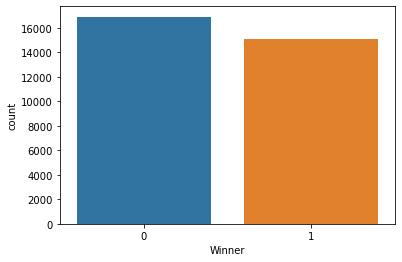

In [31]:
sns.countplot(x=train['Winner'])

<AxesSubplot:xlabel='Winner', ylabel='count'>

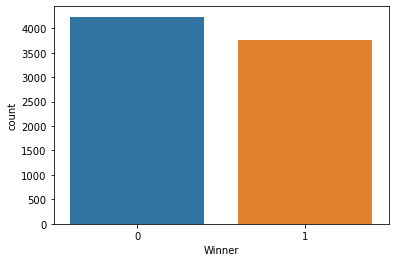

In [32]:
sns.countplot(x=test['Winner'])

#### Notiamo che i valori sono distribuiti in maniera abbastanza omogenea sia nel dataset di train sia nel dataset di test

# Vedo se si può assumere da questi grafici l'importanza di alcune feature del dataset

### - Generation

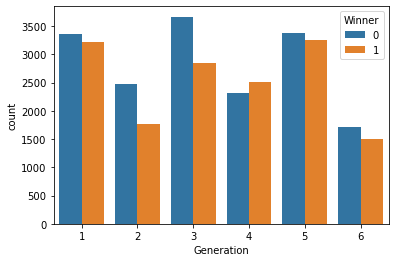

In [33]:
sns.countplot(x=train["Generation"],hue=train["Winner"]);

#### La feature Generation sembrerebbe superflua.

### - SPEED

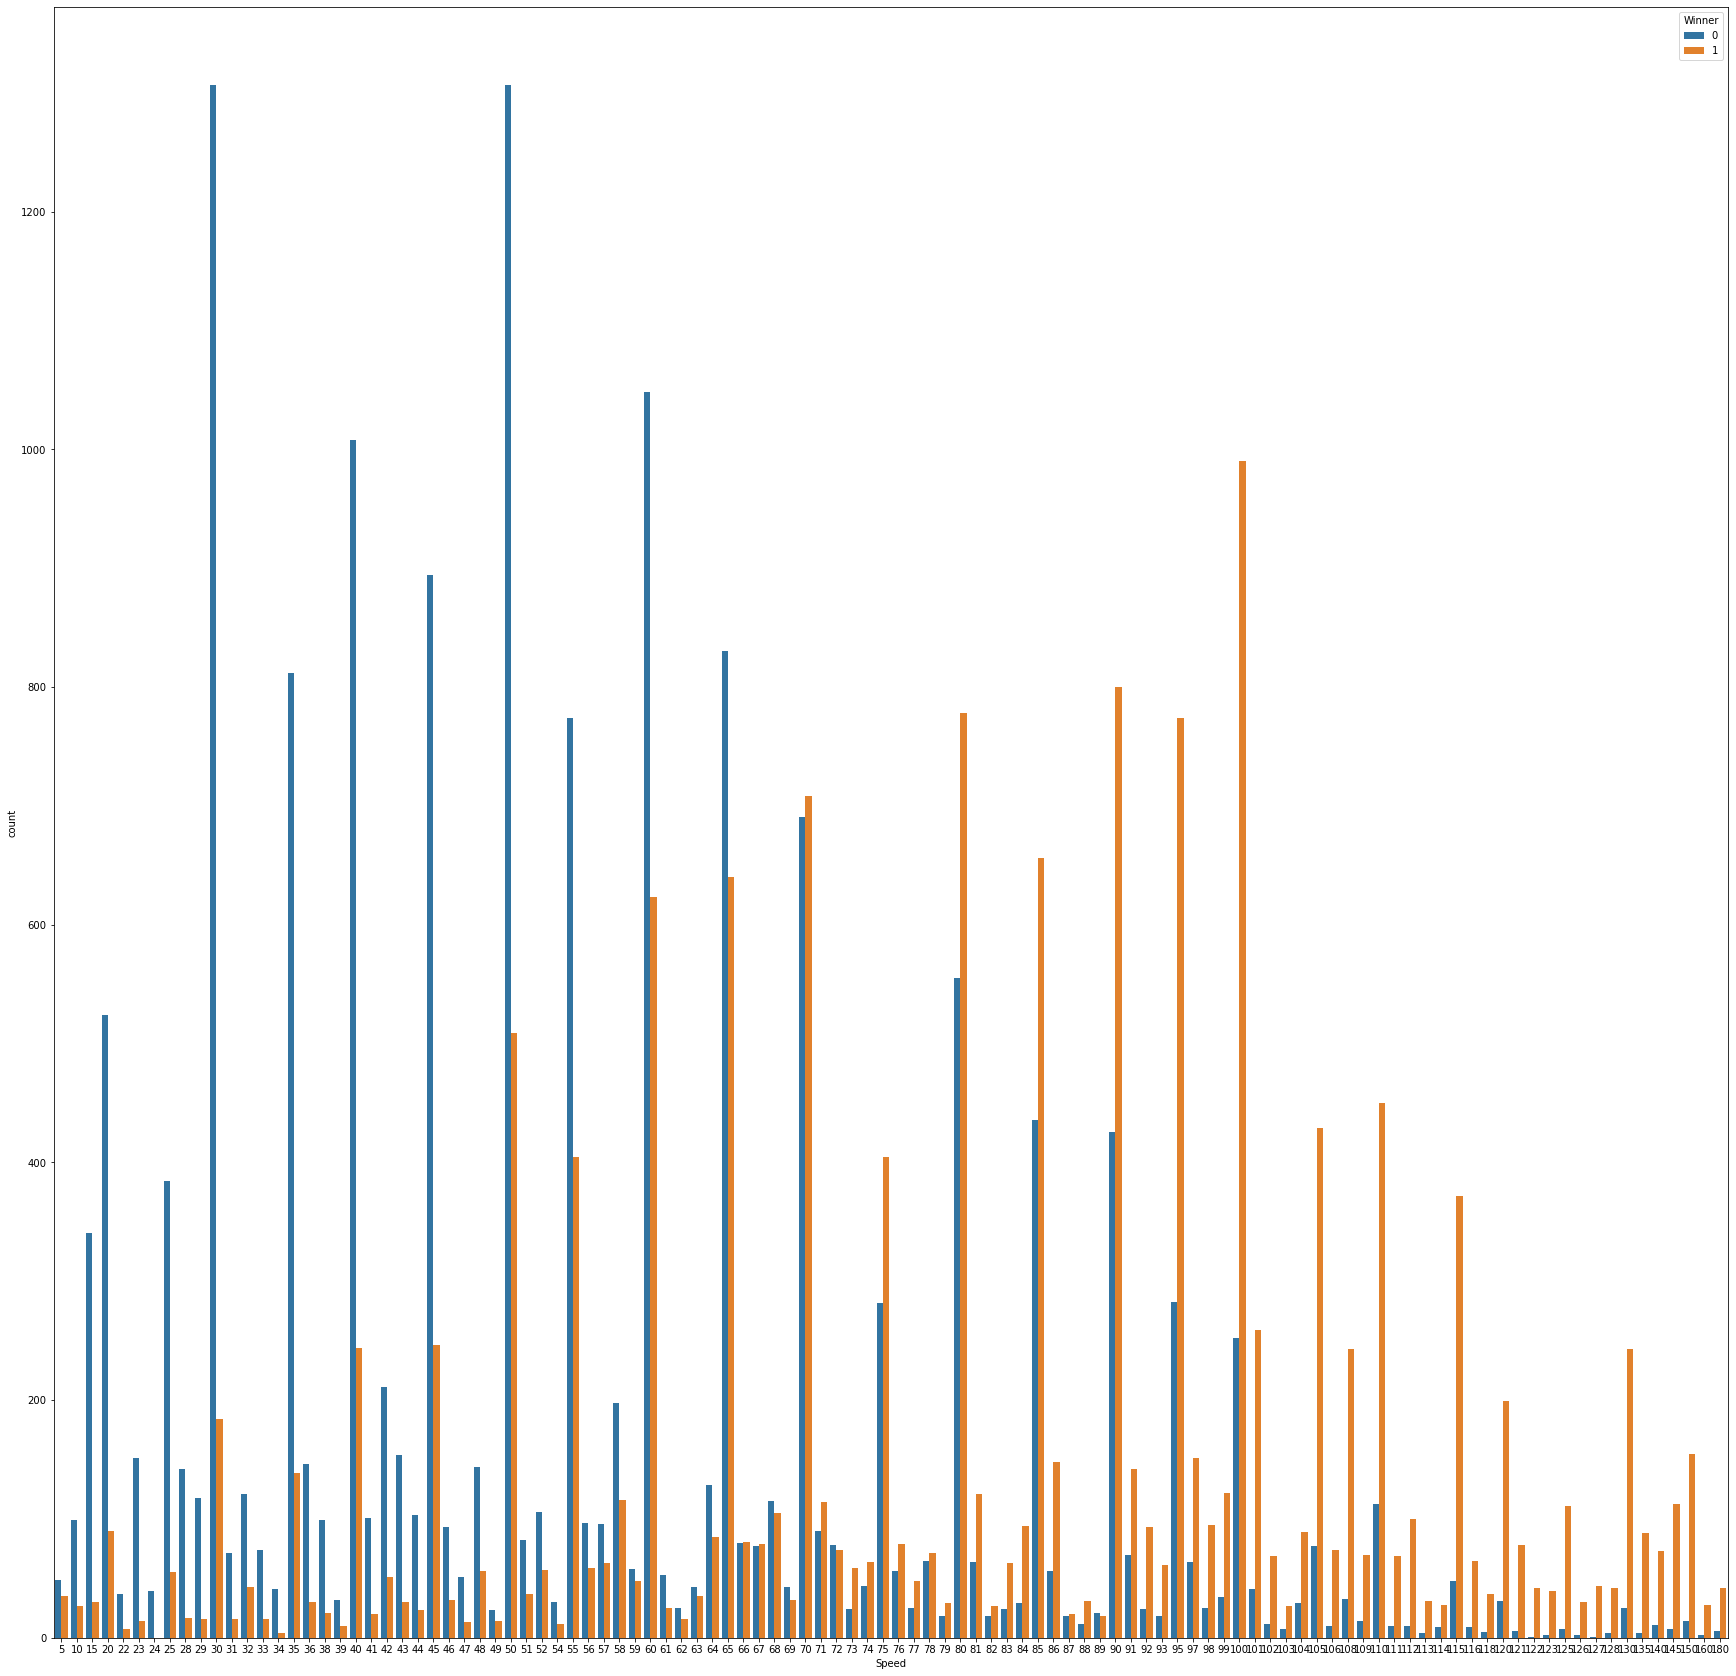

In [34]:
plt.figure(figsize=(30,30))
sns.countplot(x=train["Speed"],hue=train["Winner"]);

#### Dal grafico di sopra possiamo notare come la distribuzione non sia del tutto omogenea, quindi per capire meglio la relazione:
## - Definisco quindi una nuova Feature che mi rappresenta la differenza fra la stats 'Speed' dei due Pokemon

### - DIFF_SPEED

In [35]:
train['diff_Speed']=train['Speed']-train['Speed_second']
test['diff_Speed']=test['Speed']-test['Speed_second']

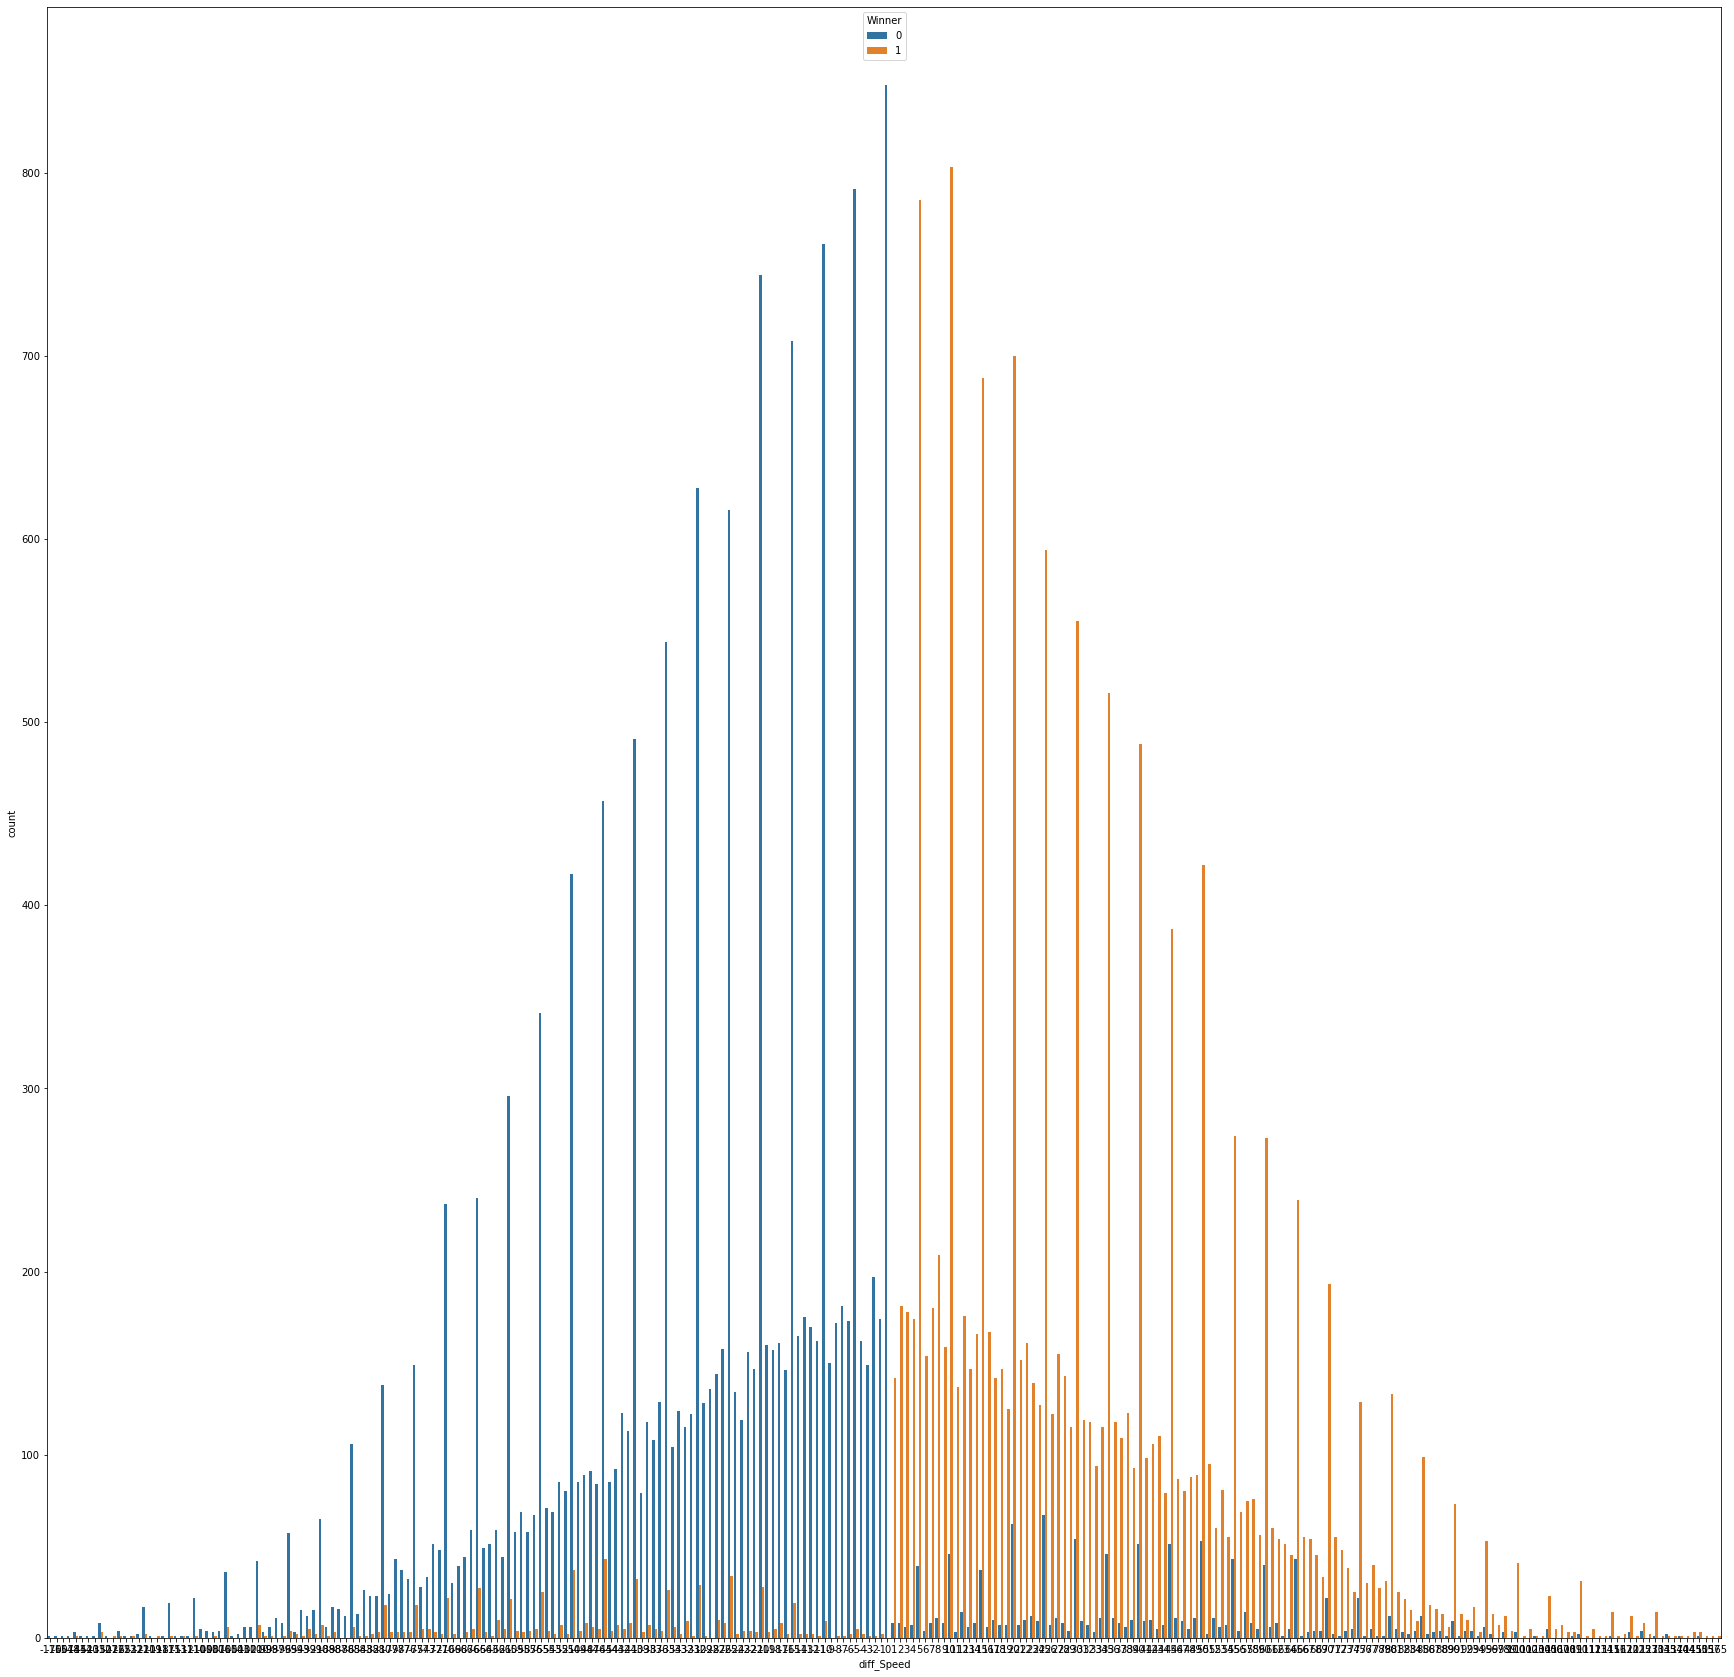

In [36]:
plt.figure(figsize=(30,30))
sns.countplot(x=train["diff_Speed"],hue=train["Winner"]);

### DA QUESTO GRAFICO RISULTA MOLTO PIU' EVIDENTE COME CAMBIA WINNER IN BASE ALLA VELOCITA'
OVVERO I POKEMON CHE POSSIEDONO VELOCITA' PIU ALTE TENDONO A VINCERE. 
- INFATTI DIFFERENZA POSITIVA VUOL DIRE CHE IL PRIMO E' PIU' VELOCE DEL SECONDO -> VINCE IL PRIMO, E INFATTI WINNER=1
- INVECE DIFFERENZA NEGATIVA VUOL DIRE CHE IL SECONDO E' PIU' VELOCE DEL PRIMO -> VINCE IL SECONDO, E INFATTI WINNER=0

### -HP

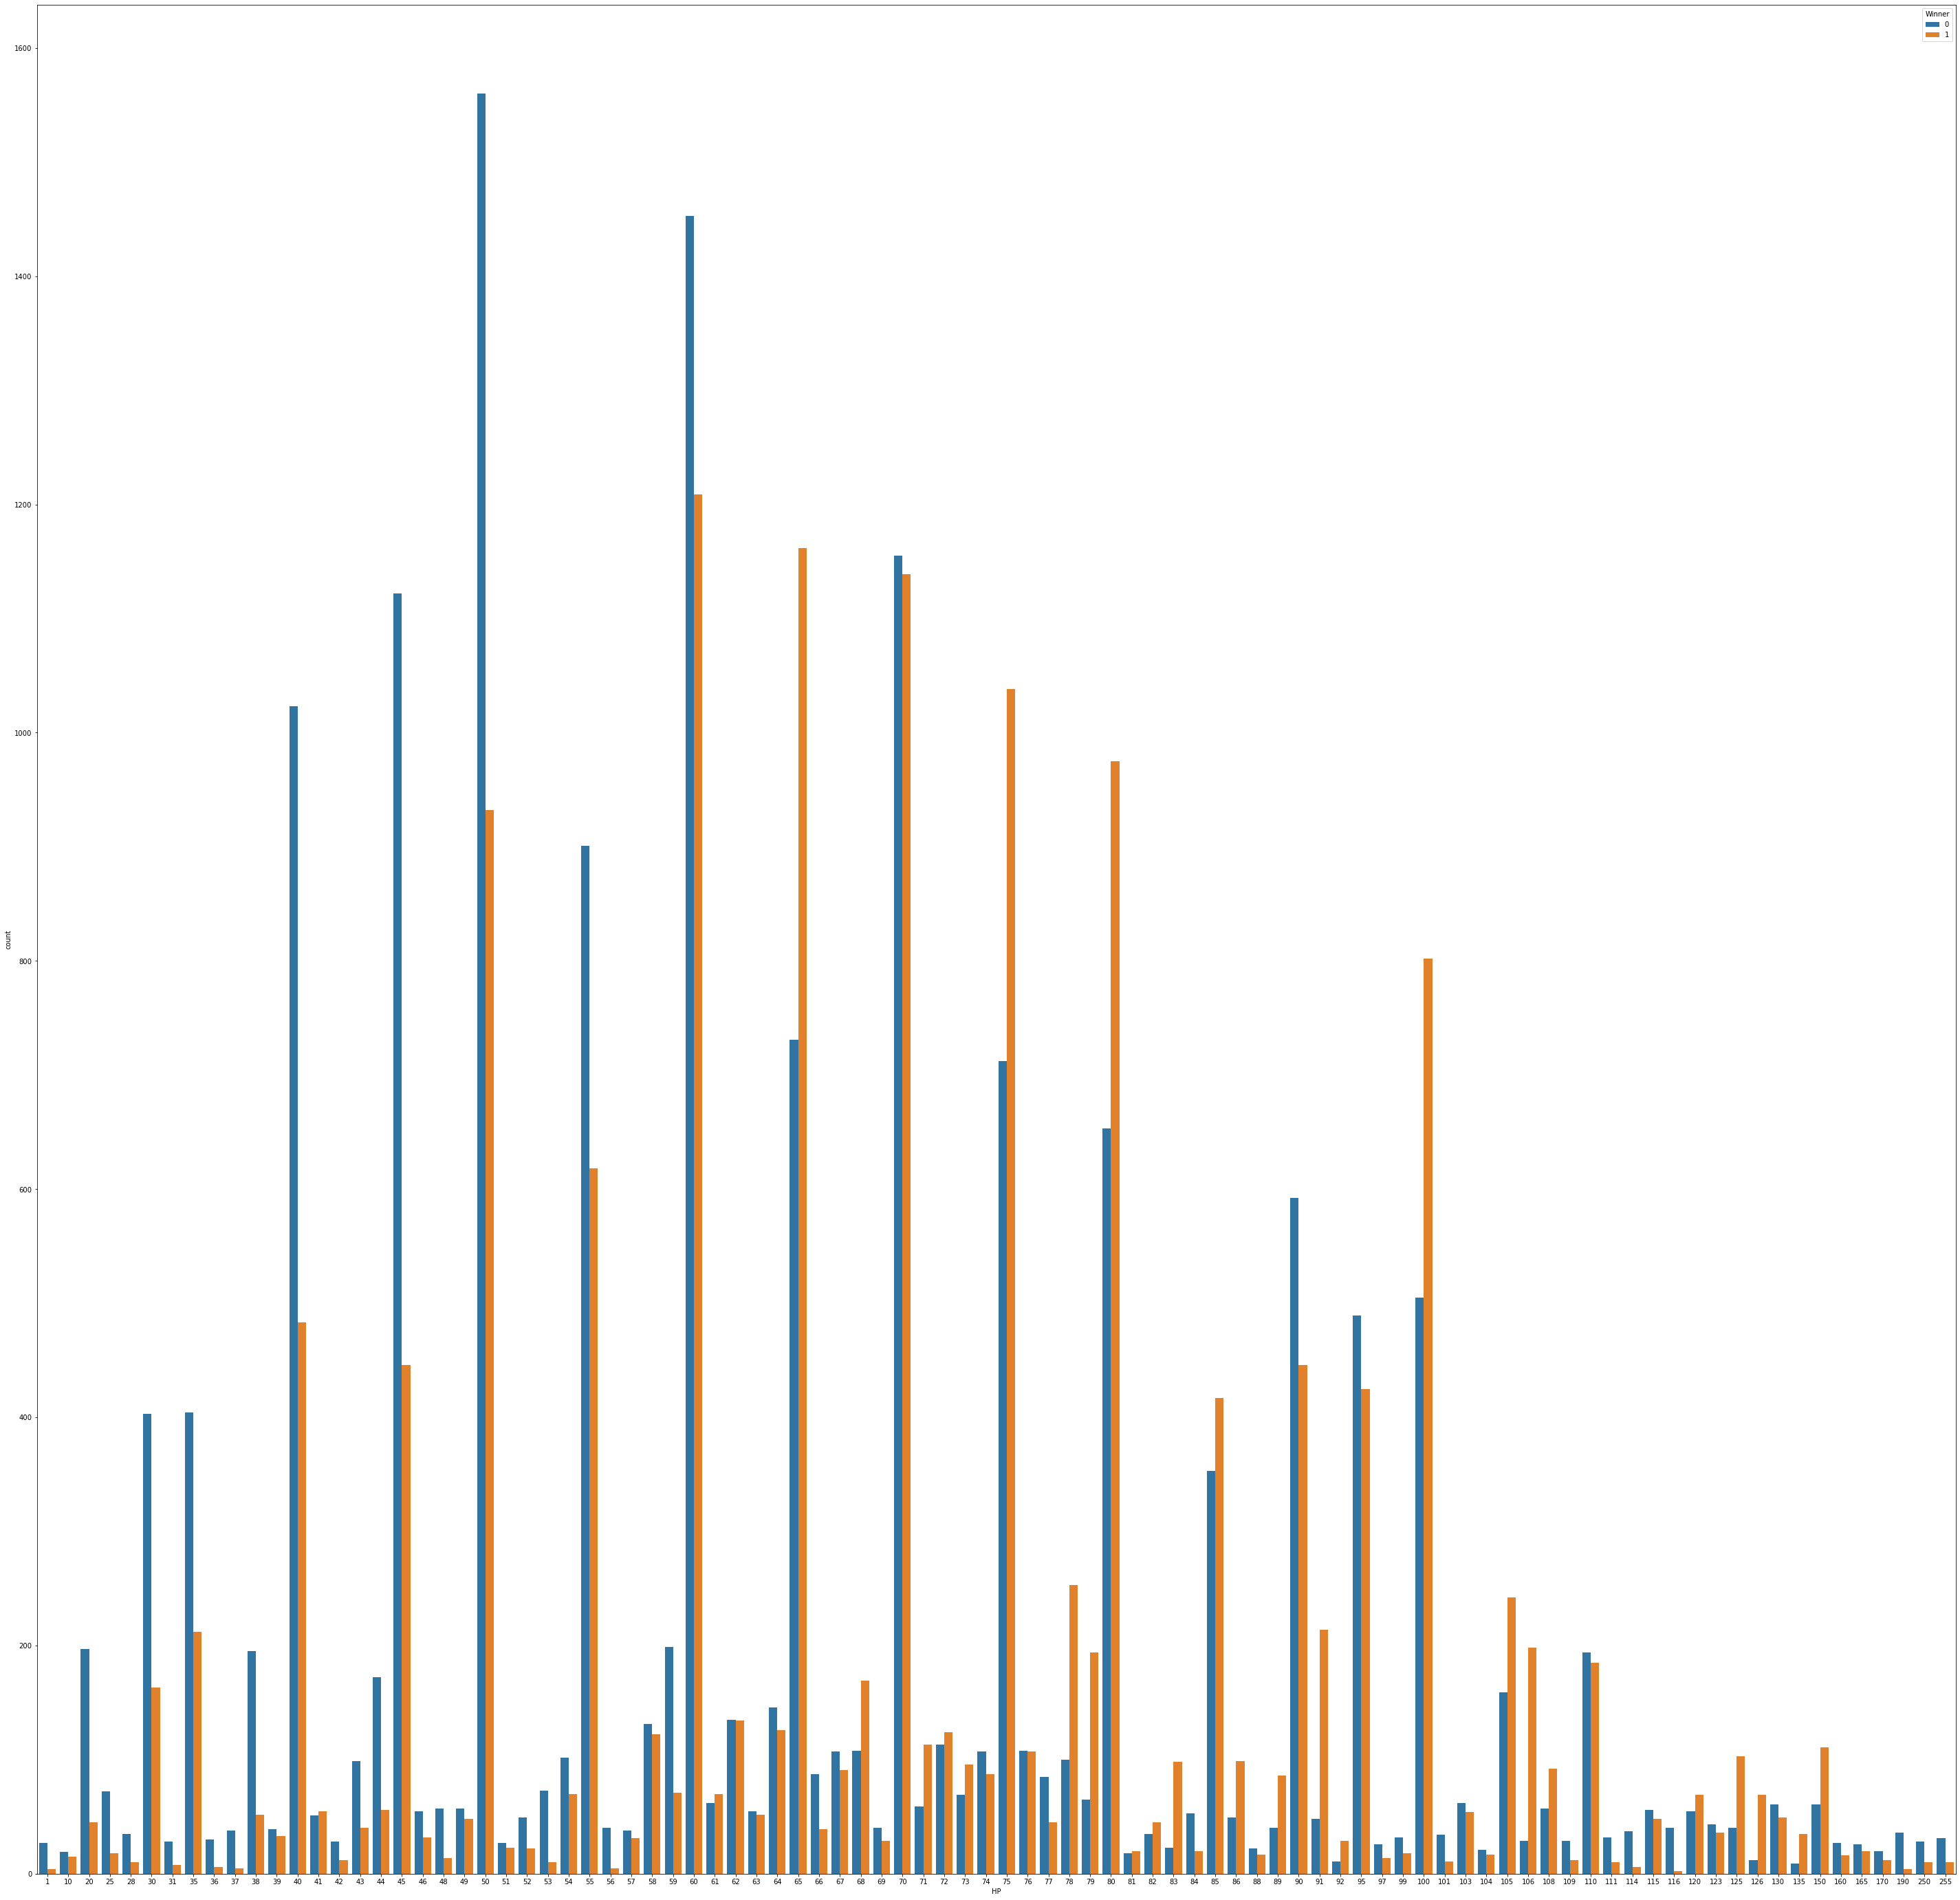

In [37]:
plt.figure(figsize=(50,50))
sns.countplot(x=train["HP"],hue=train["Winner"]);

DA QUESTO GRAFICO SEMBREREBBE CHE HP NON SIA COSI' TANTO UTILE IN MOLYI PUNTI I WINNER=0 O I WINNER=2 SONO PARAGONABILI, PROVO QUINDI A DEFINIRE UNA NUOVA FEATURE CHE MI RAPPRESENTA LA DIFFERENZA FRA HP DEL POKEMON1 E LA HP DEL POKEMON 2

### -DIFF_HP

In [38]:
train['diff_HP']=train['HP']-train['HP_second']
test['diff_HP']= test['HP']- test['HP_second']

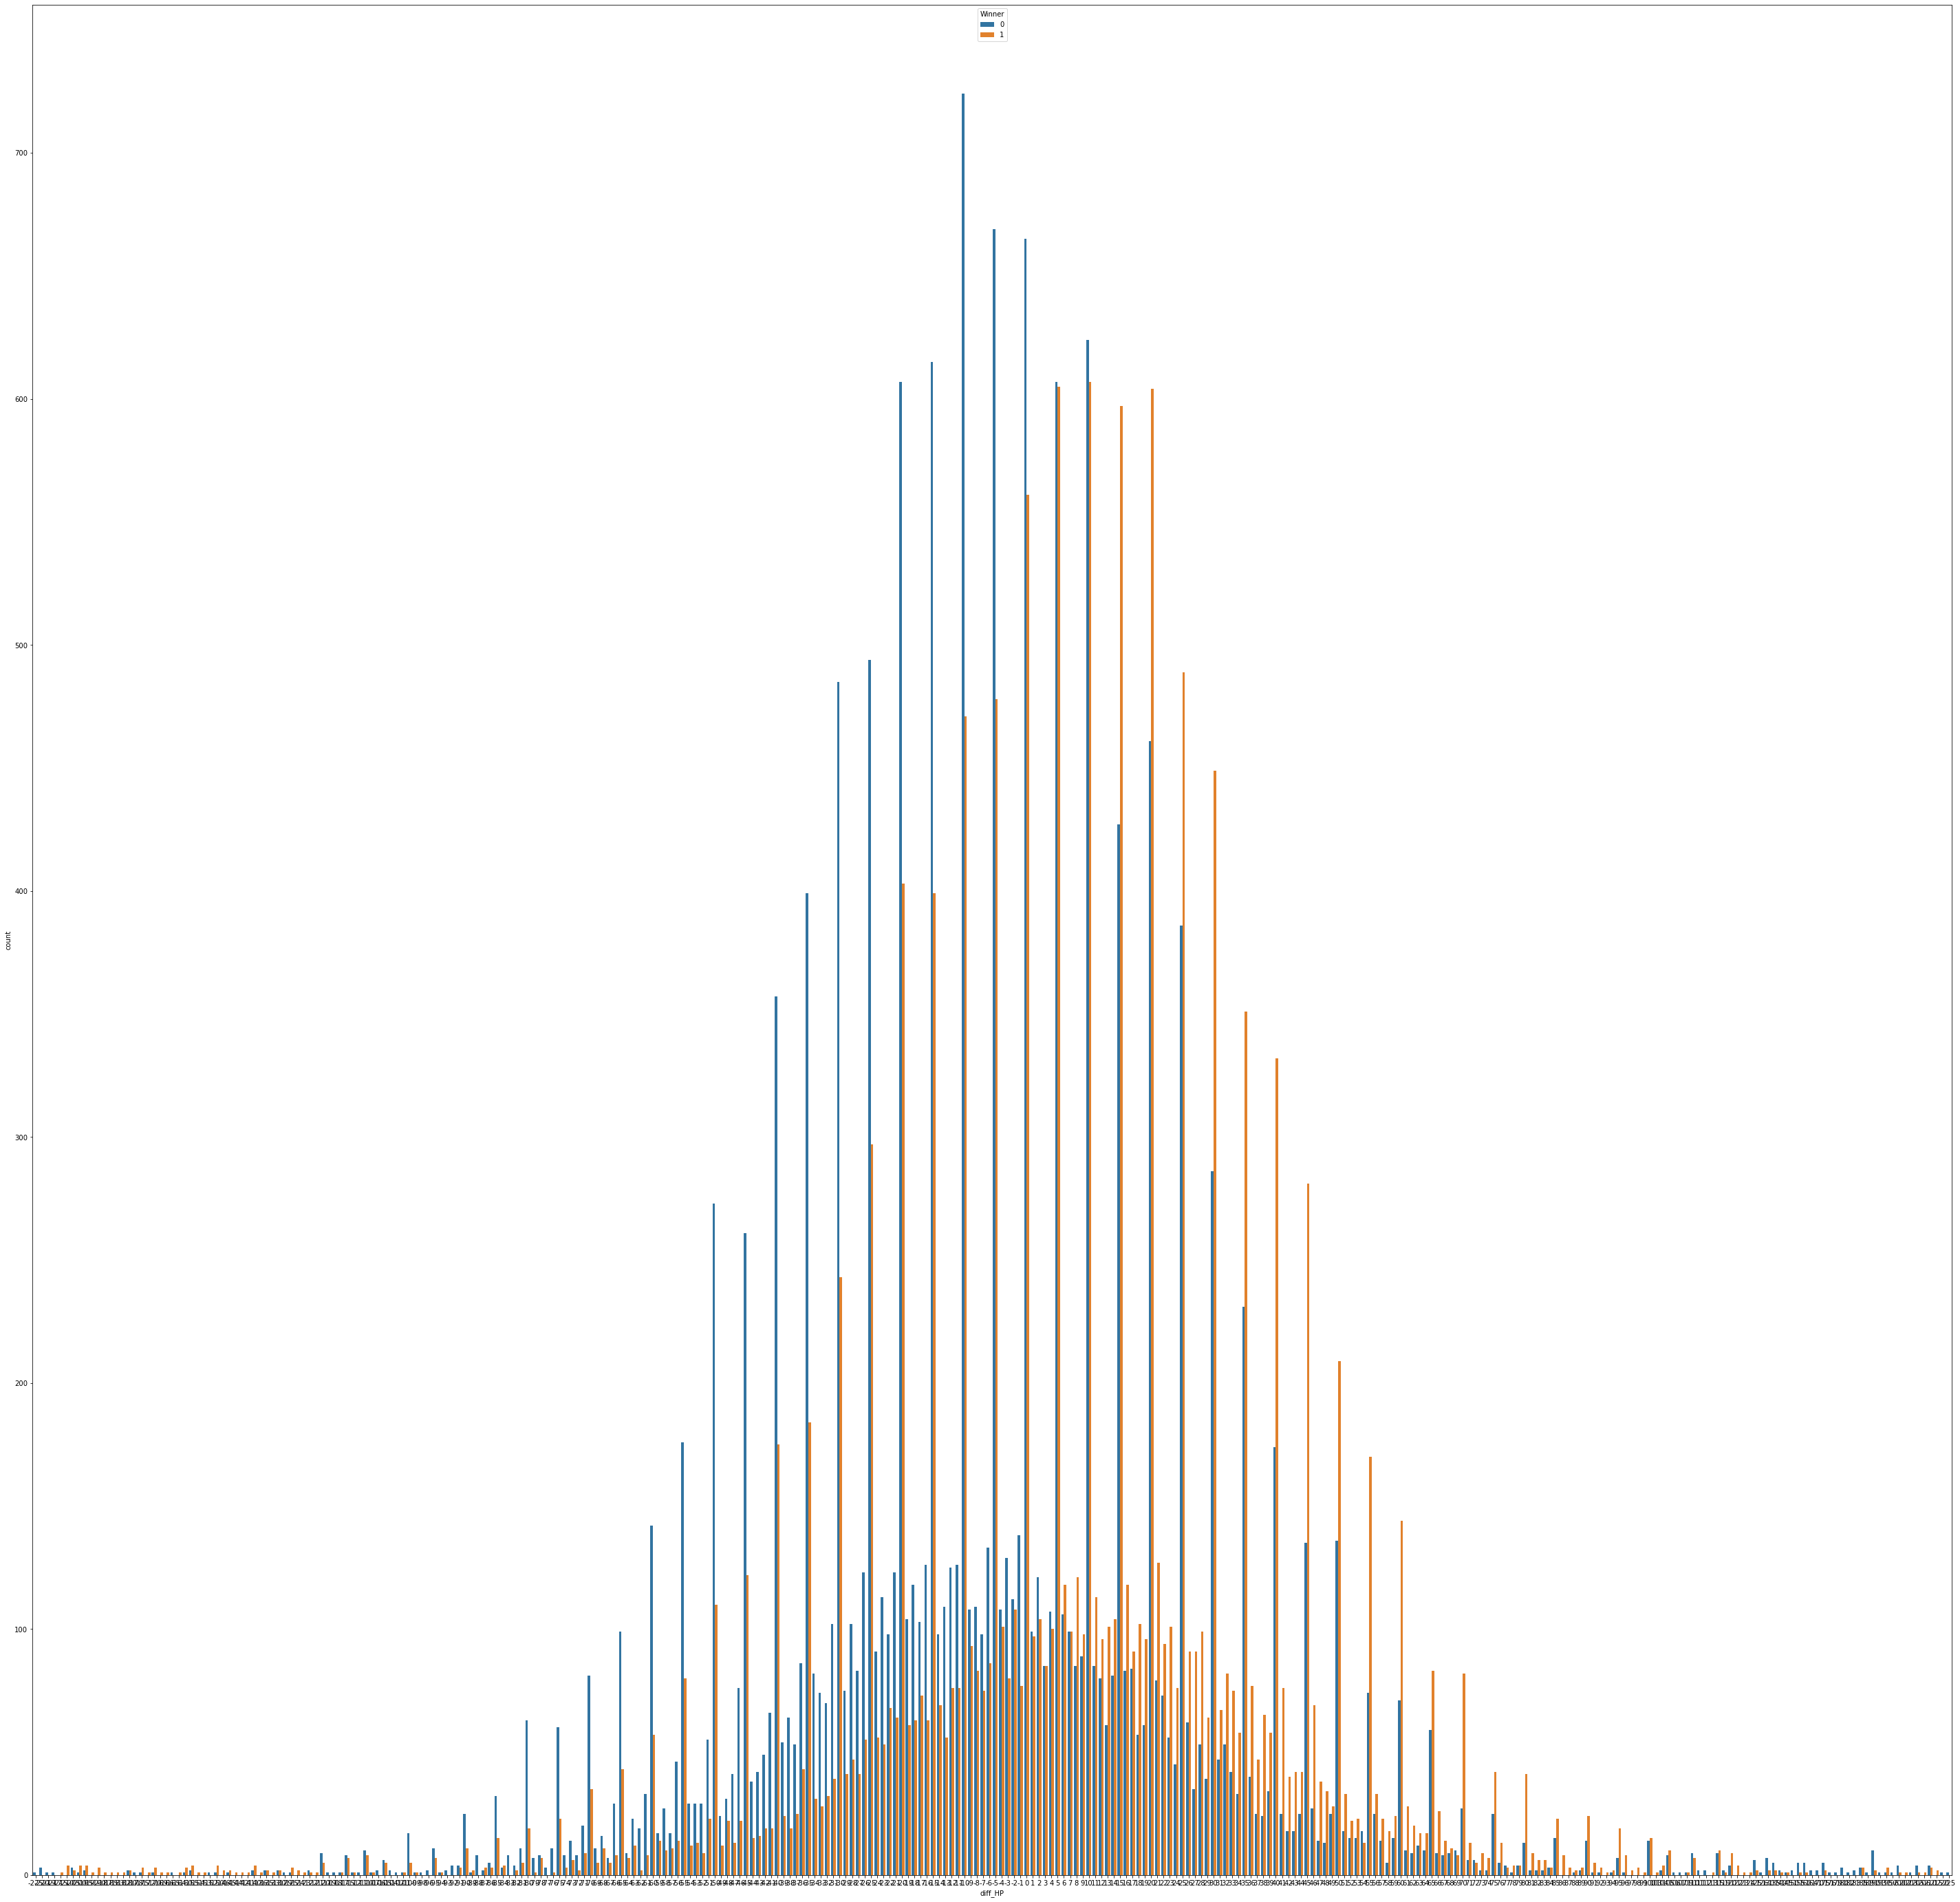

In [39]:
plt.figure(figsize=(50,50))
sns.countplot(x=train["diff_HP"],hue=train["Winner"]);

DA QUESTO GRAFICO A PRIMO IMPATTO SEMBREREBBE CHE:
- se il pokemon2 ha HP maggiore del pokemon1 vince il 2 
- se il pokemon1 ha HP maggiore del pokemon2 vince il 1
Però questa volta non basta avere HP maggiore per vincere, in quanto per valori di HP vicini allo 0 troviamo che winner sia paragonabile

### - ATTACK

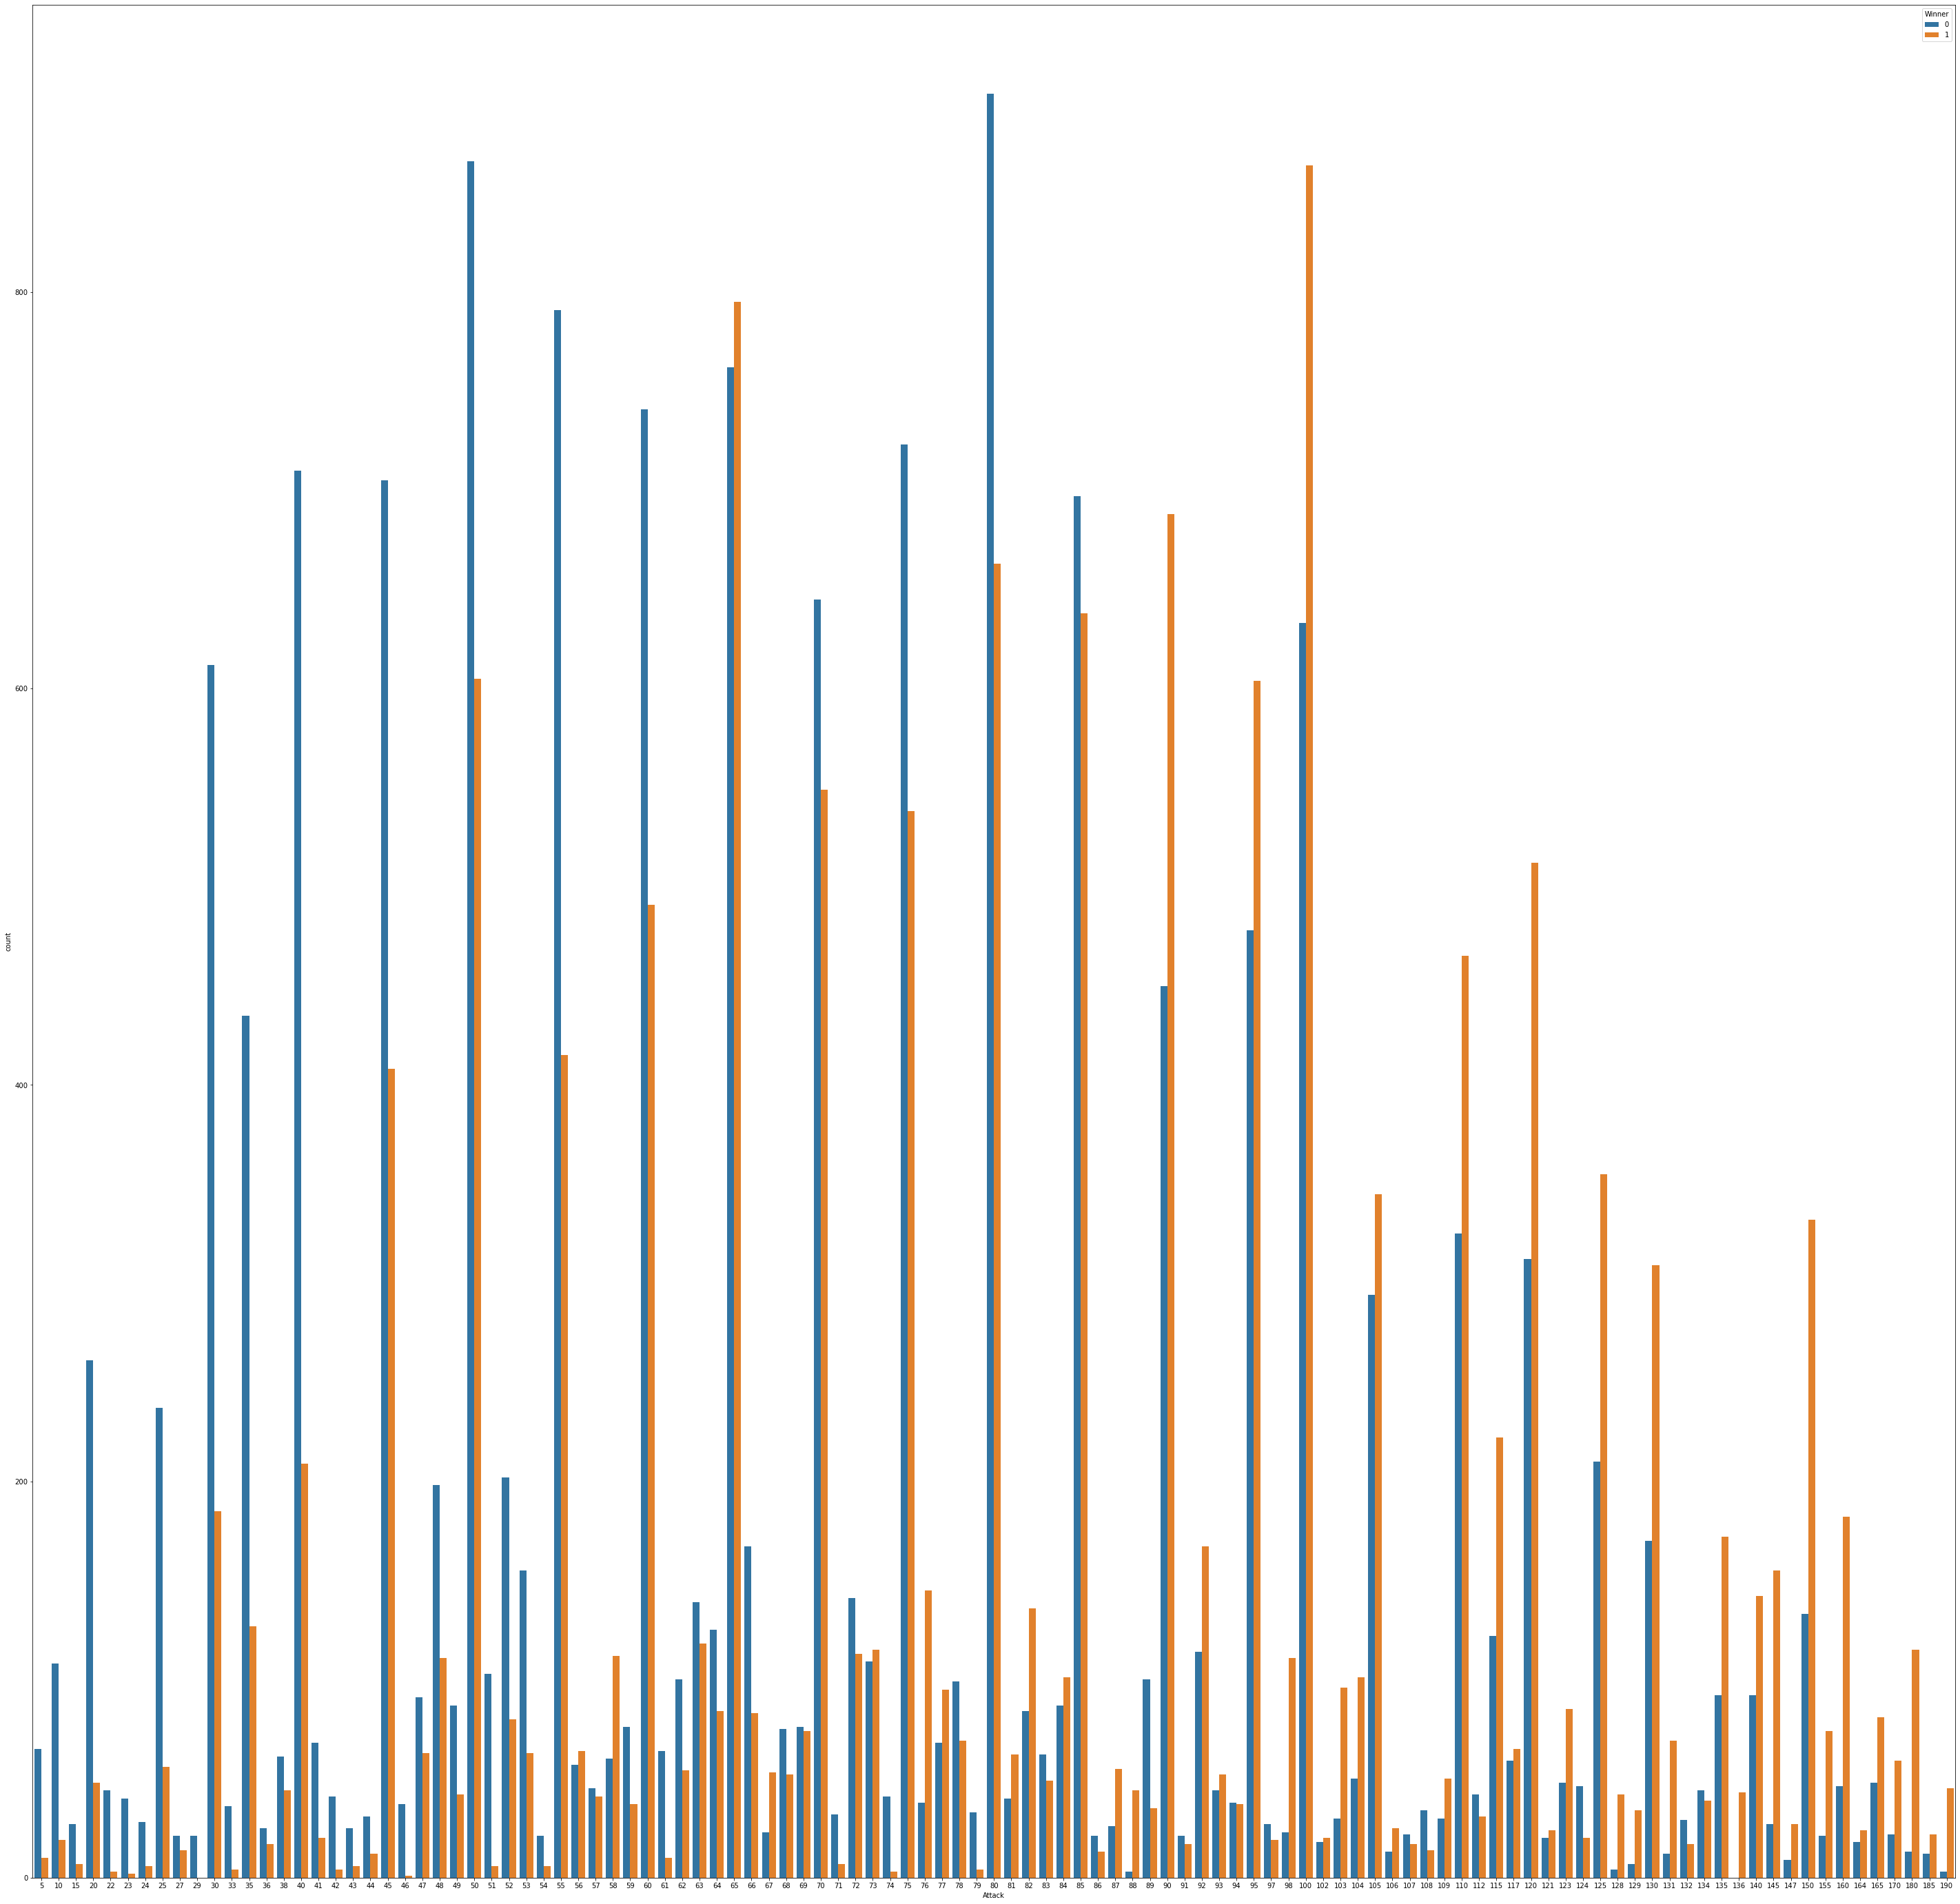

In [40]:
plt.figure(figsize=(50,50))

sns.countplot(x=train["Attack"],hue=train["Winner"]);

QUESTO GRAFICO COSI' NON SEMBRA ESSERE MOLTO RILEVANTE: 
VEDIAMO SEMPLICEMENTE CHE I PICCHI SI HANNO MA PER ALCUNI VALORI DI ATTACO SONO MOLTO PARAGONABILI
QUINDI DEFINISCO UNA FEATURE CHE MI RAPPRESENTA LA DIFFERENZA FRA I DUE ATTACCHI PER PROVARE AD OTTENERE UN QUALCOSA DI PIU' INTERESSANTE

### - DIFF_ATTACK

In [41]:
train['diff_Attack']=train['Attack']-train['Attack_second']
test['diff_Attack']=test['Attack']-test['Attack_second']


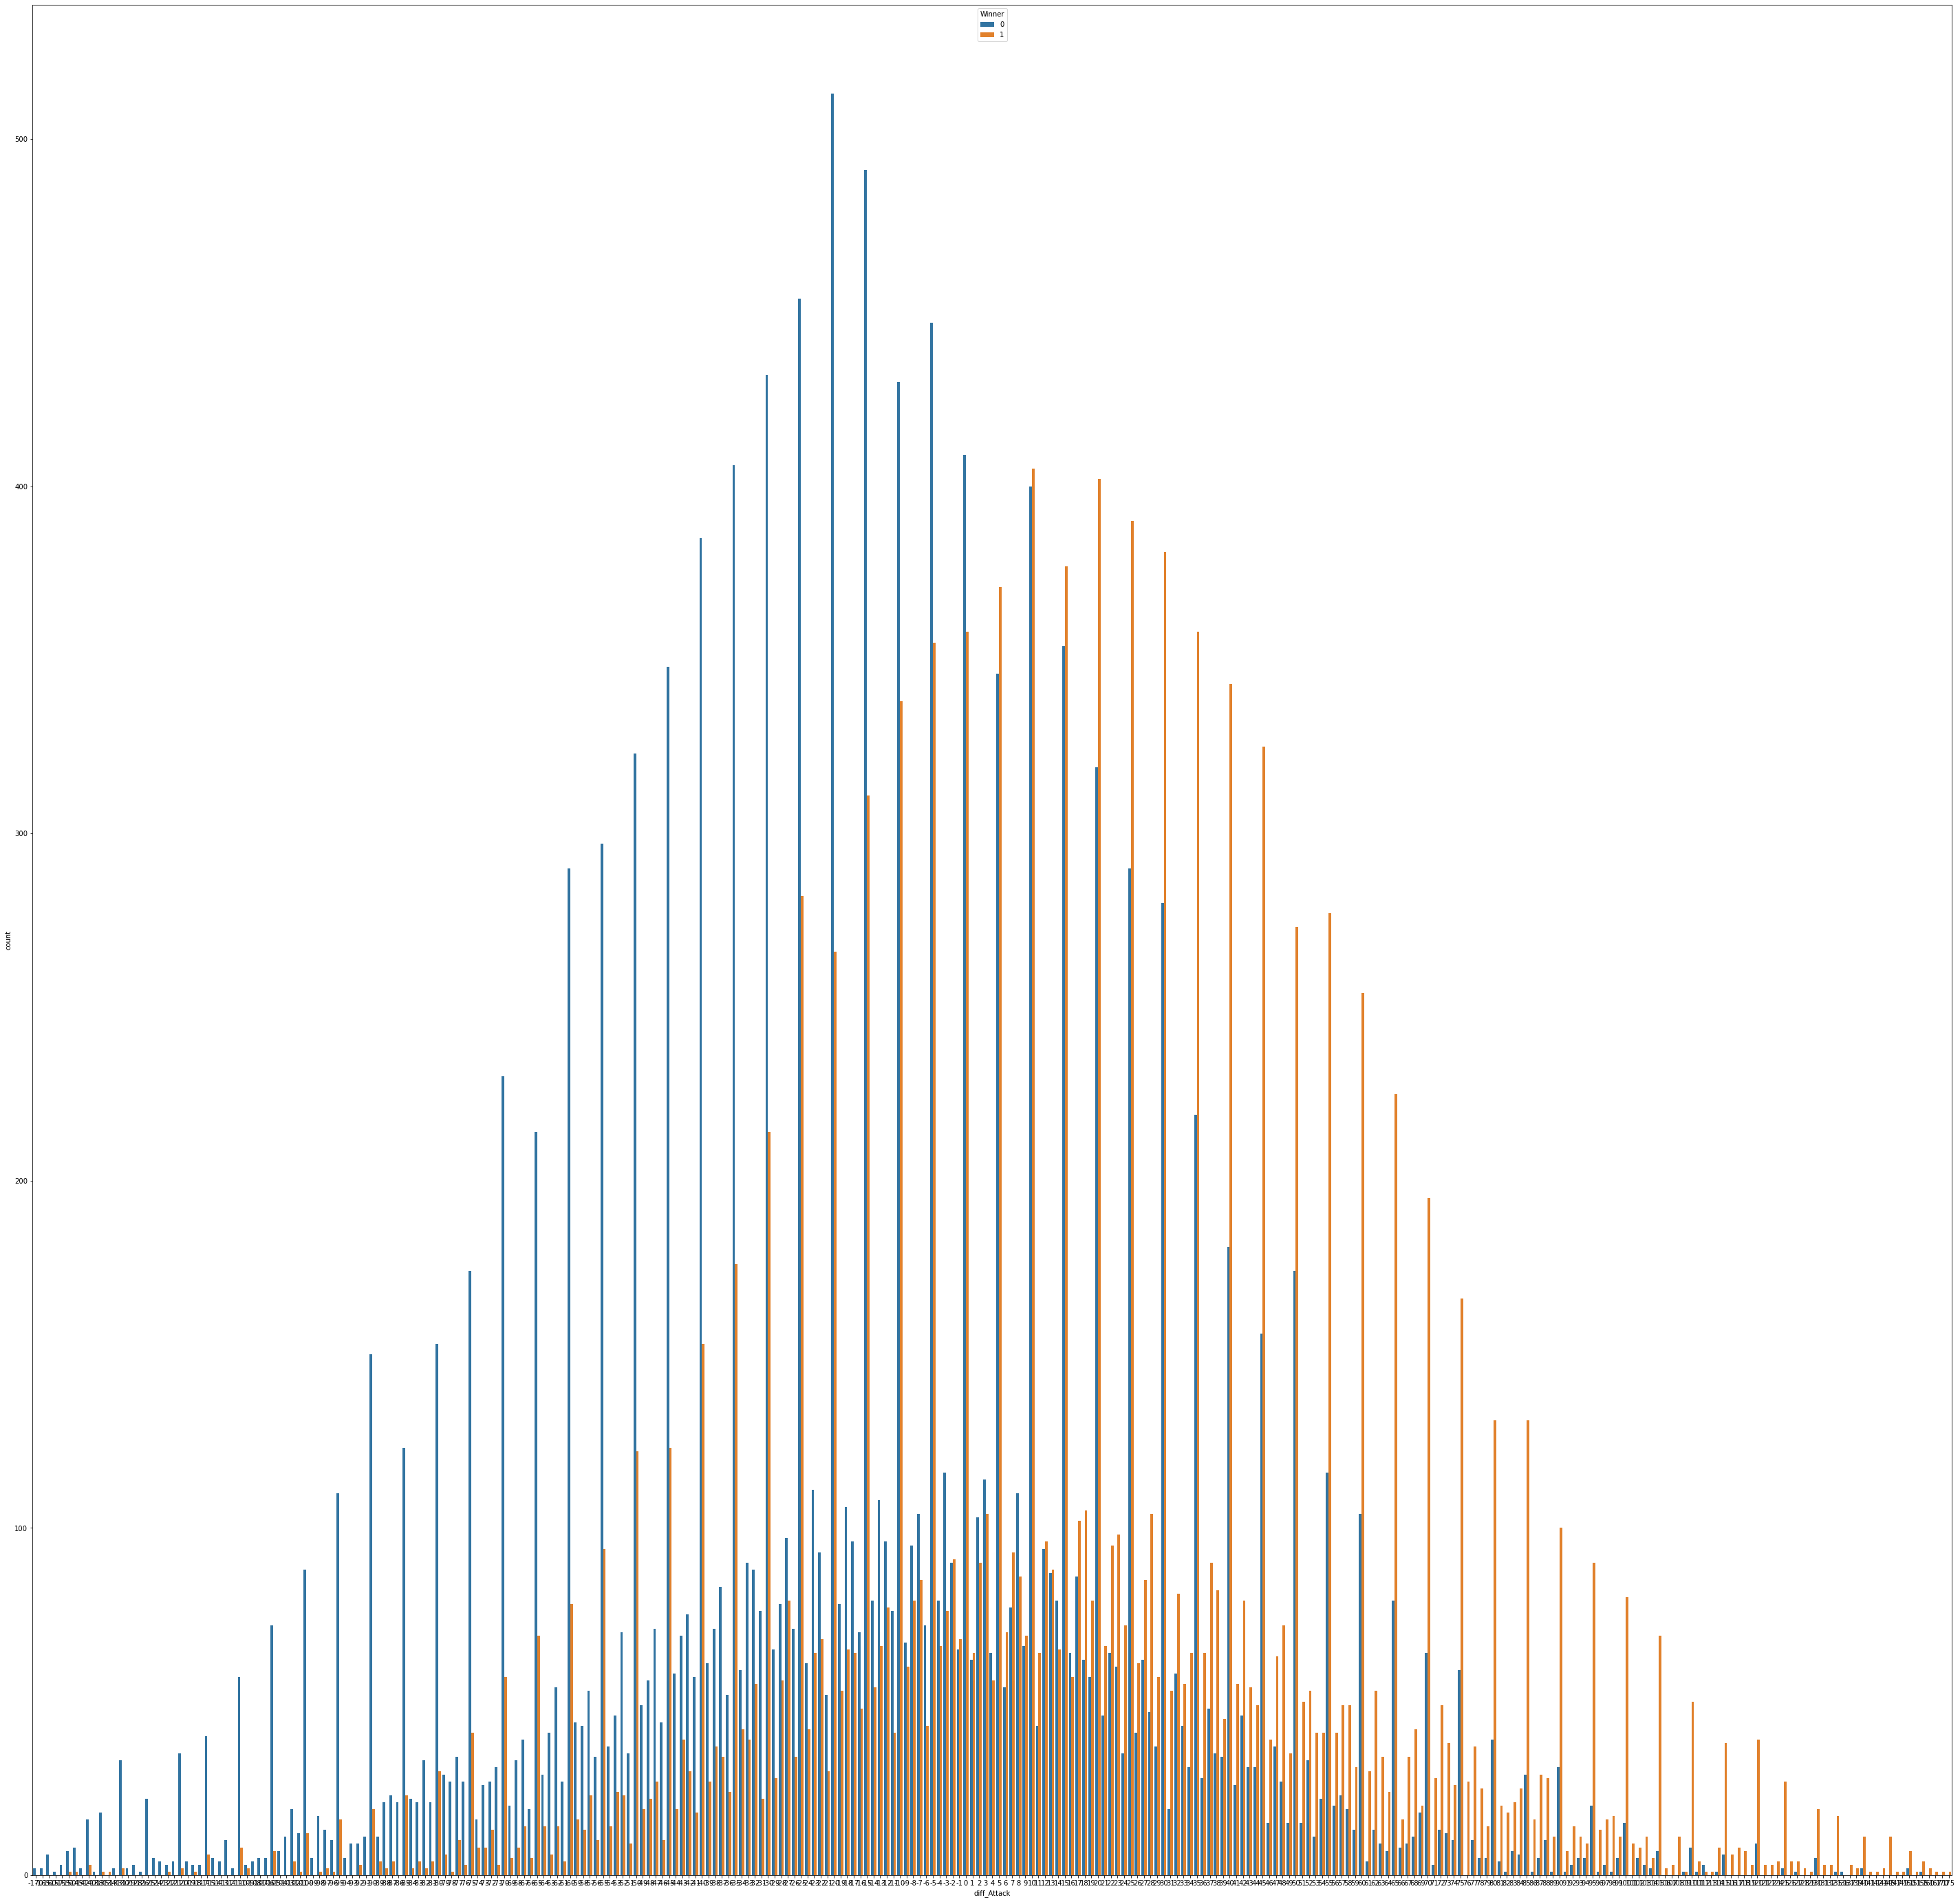

In [42]:
plt.figure(figsize=(50,50))
sns.countplot(x=train["diff_Attack"],hue=train["Winner"]);

DA QUESTO GRAFICO SI EVINCE CHE TENDENZIALMENTE:

- ATTACCO 1 MAGGIORE DELL' ATTACCO2--> vince 1
- ATTACCO 2 MAGGIORE DELL' ATTACCO1--> vince2
- PER DIFFERENZE MOLTO PICCOLE NON SI RIESCE A STABILIRE CON CERTEZZA INFATTI COME POSSIAMO VEDERE IN PROSSIMITA' DELLO 0 SONO MOLTO ALTI SIA WINNER=1 SIA WINNER=0


### DEFENSE

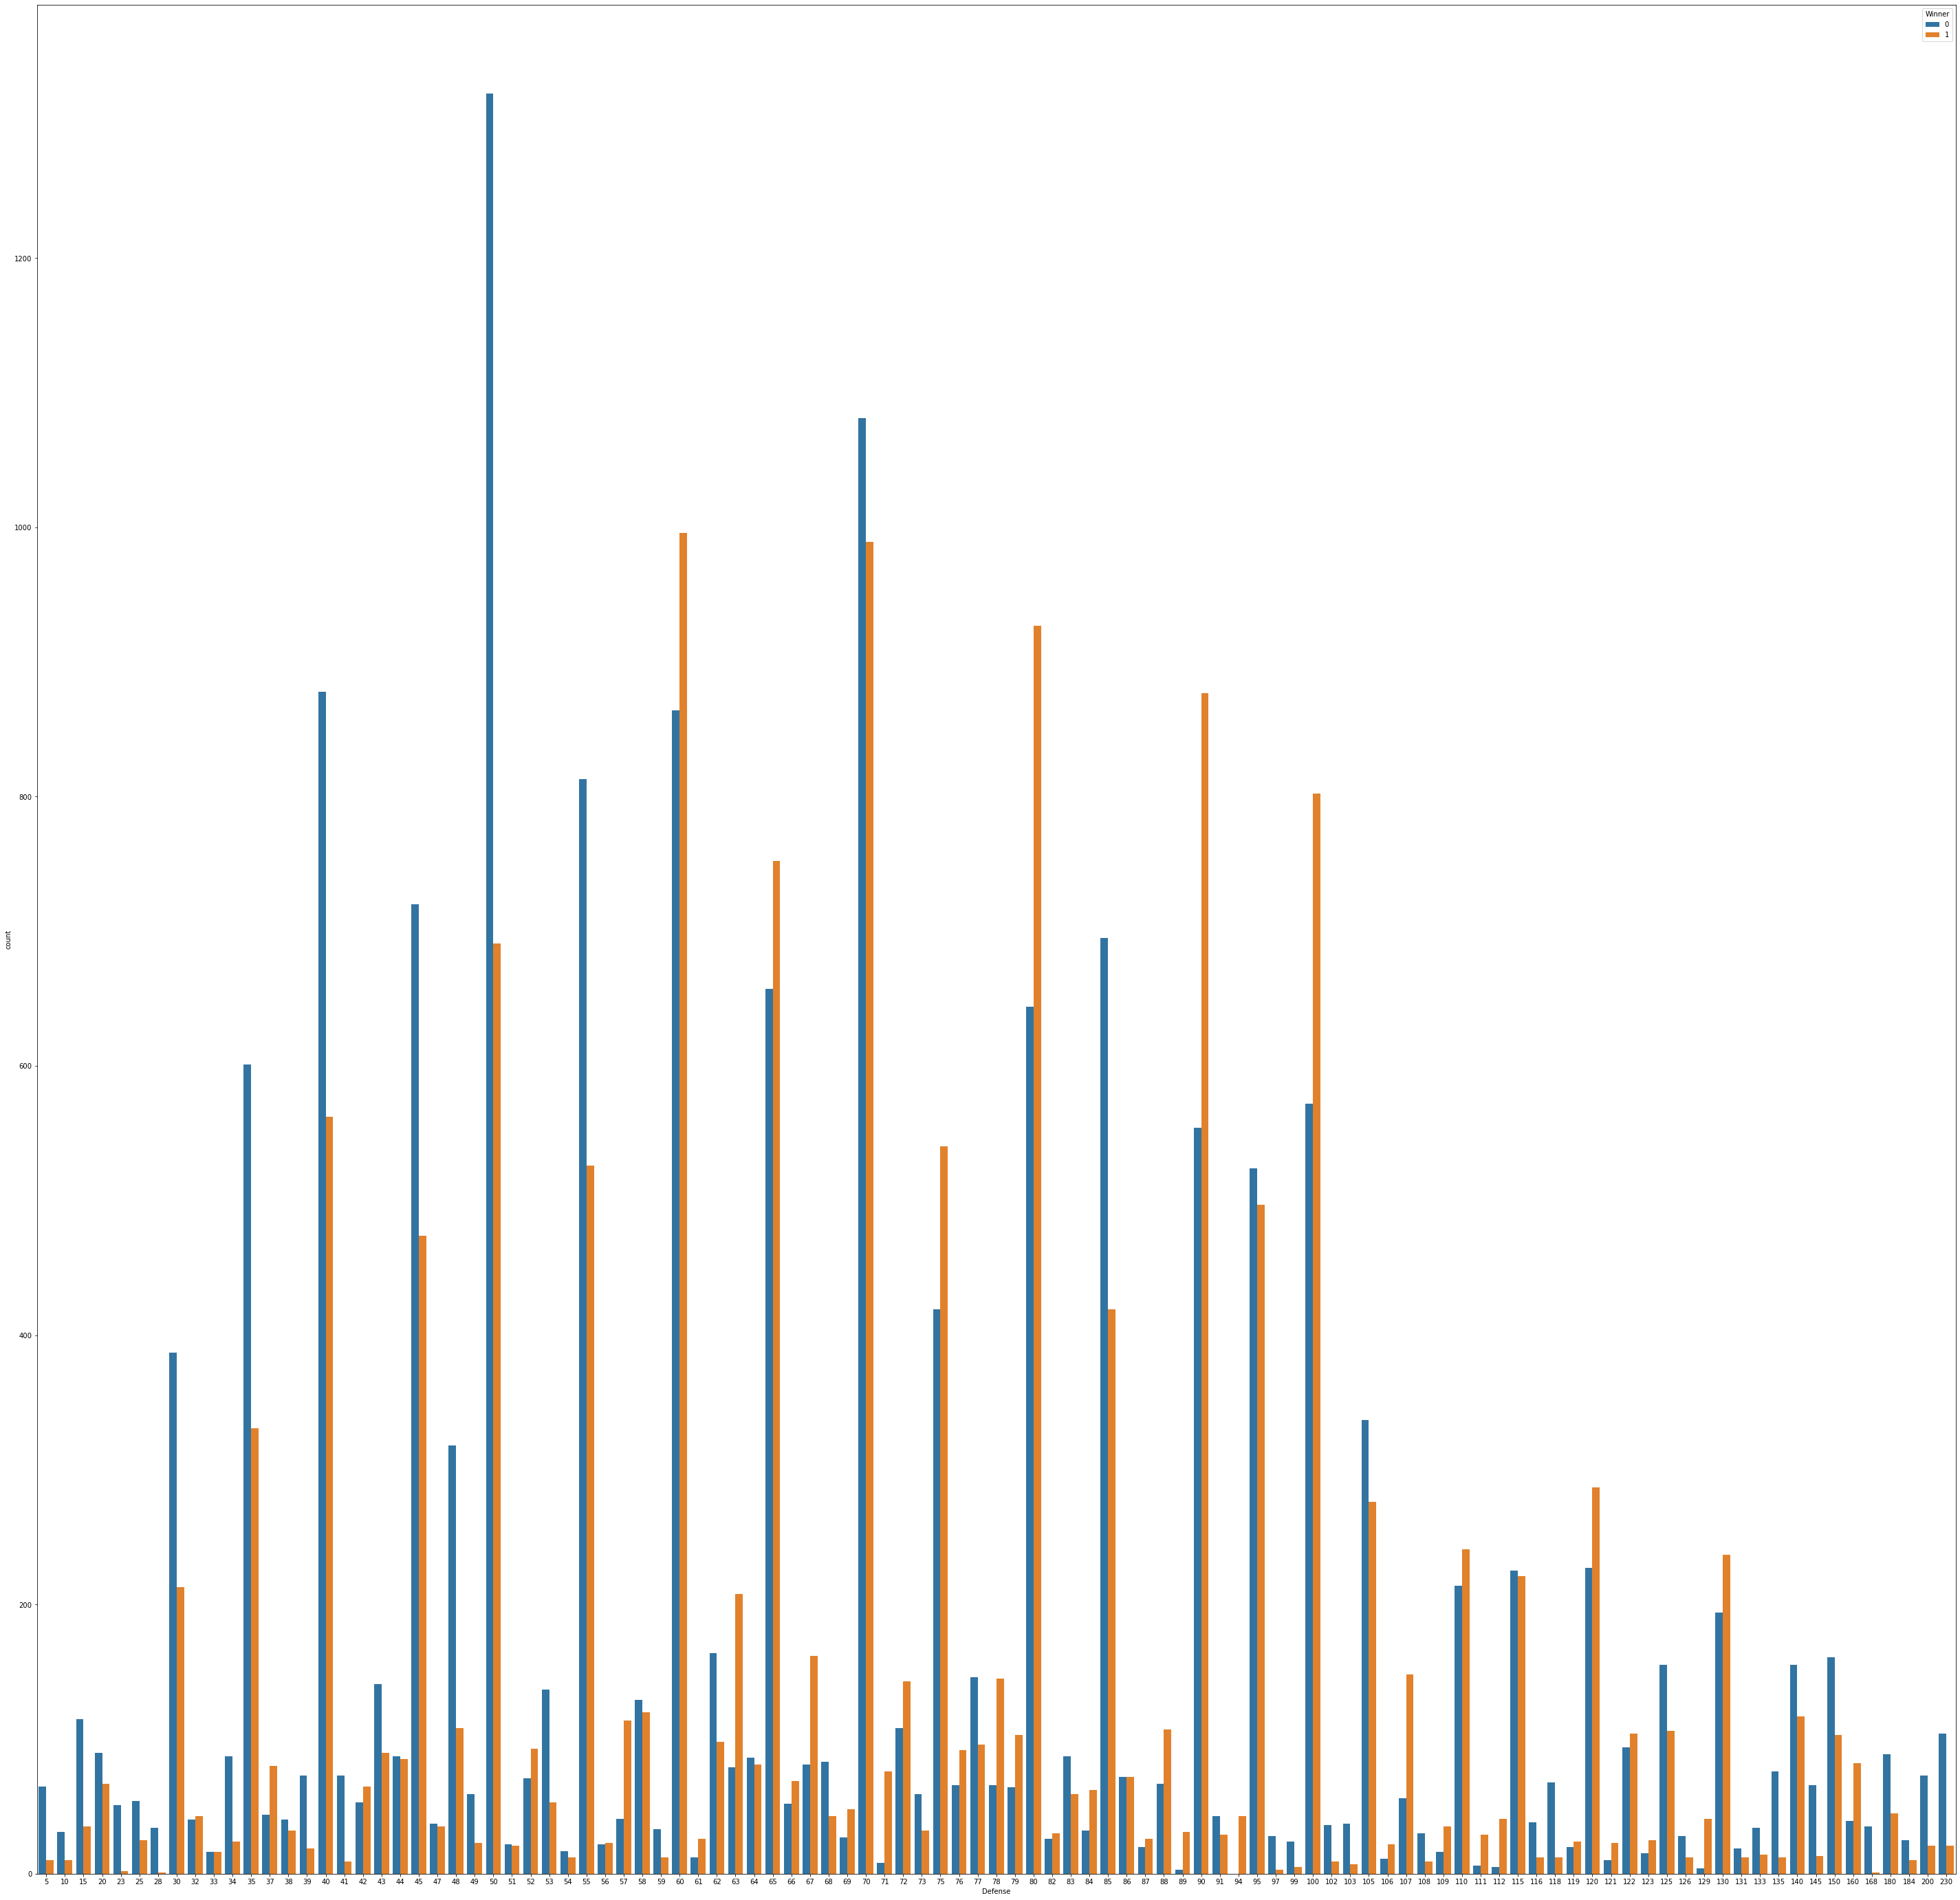

In [43]:
plt.figure(figsize=(50,50))
sns.countplot(x=train["Defense"],hue=train["Winner"]);

I VALORI IN QUESTA DISTRIBUZIONE TRANNE PER ALCUNI PUNTI ISOLATI NON DANNO INFORMAZIONI SIGNIFICATIVE  SONO INFATTI SPESSO MOLTO VICINI I VALORI DI WINNER=0 E I VALORI DI WINNER=1

VEDO SE CON LA DIFFERENZA FRA LE DUE DIFESE QUESTA COSA VIENE CONFERMATA

### -DIFF_DEFENSE

In [44]:
train['diff_Defense']=train['Defense']-train['Defense_second']
test['diff_Defense']=test['Defense']-test['Defense_second']

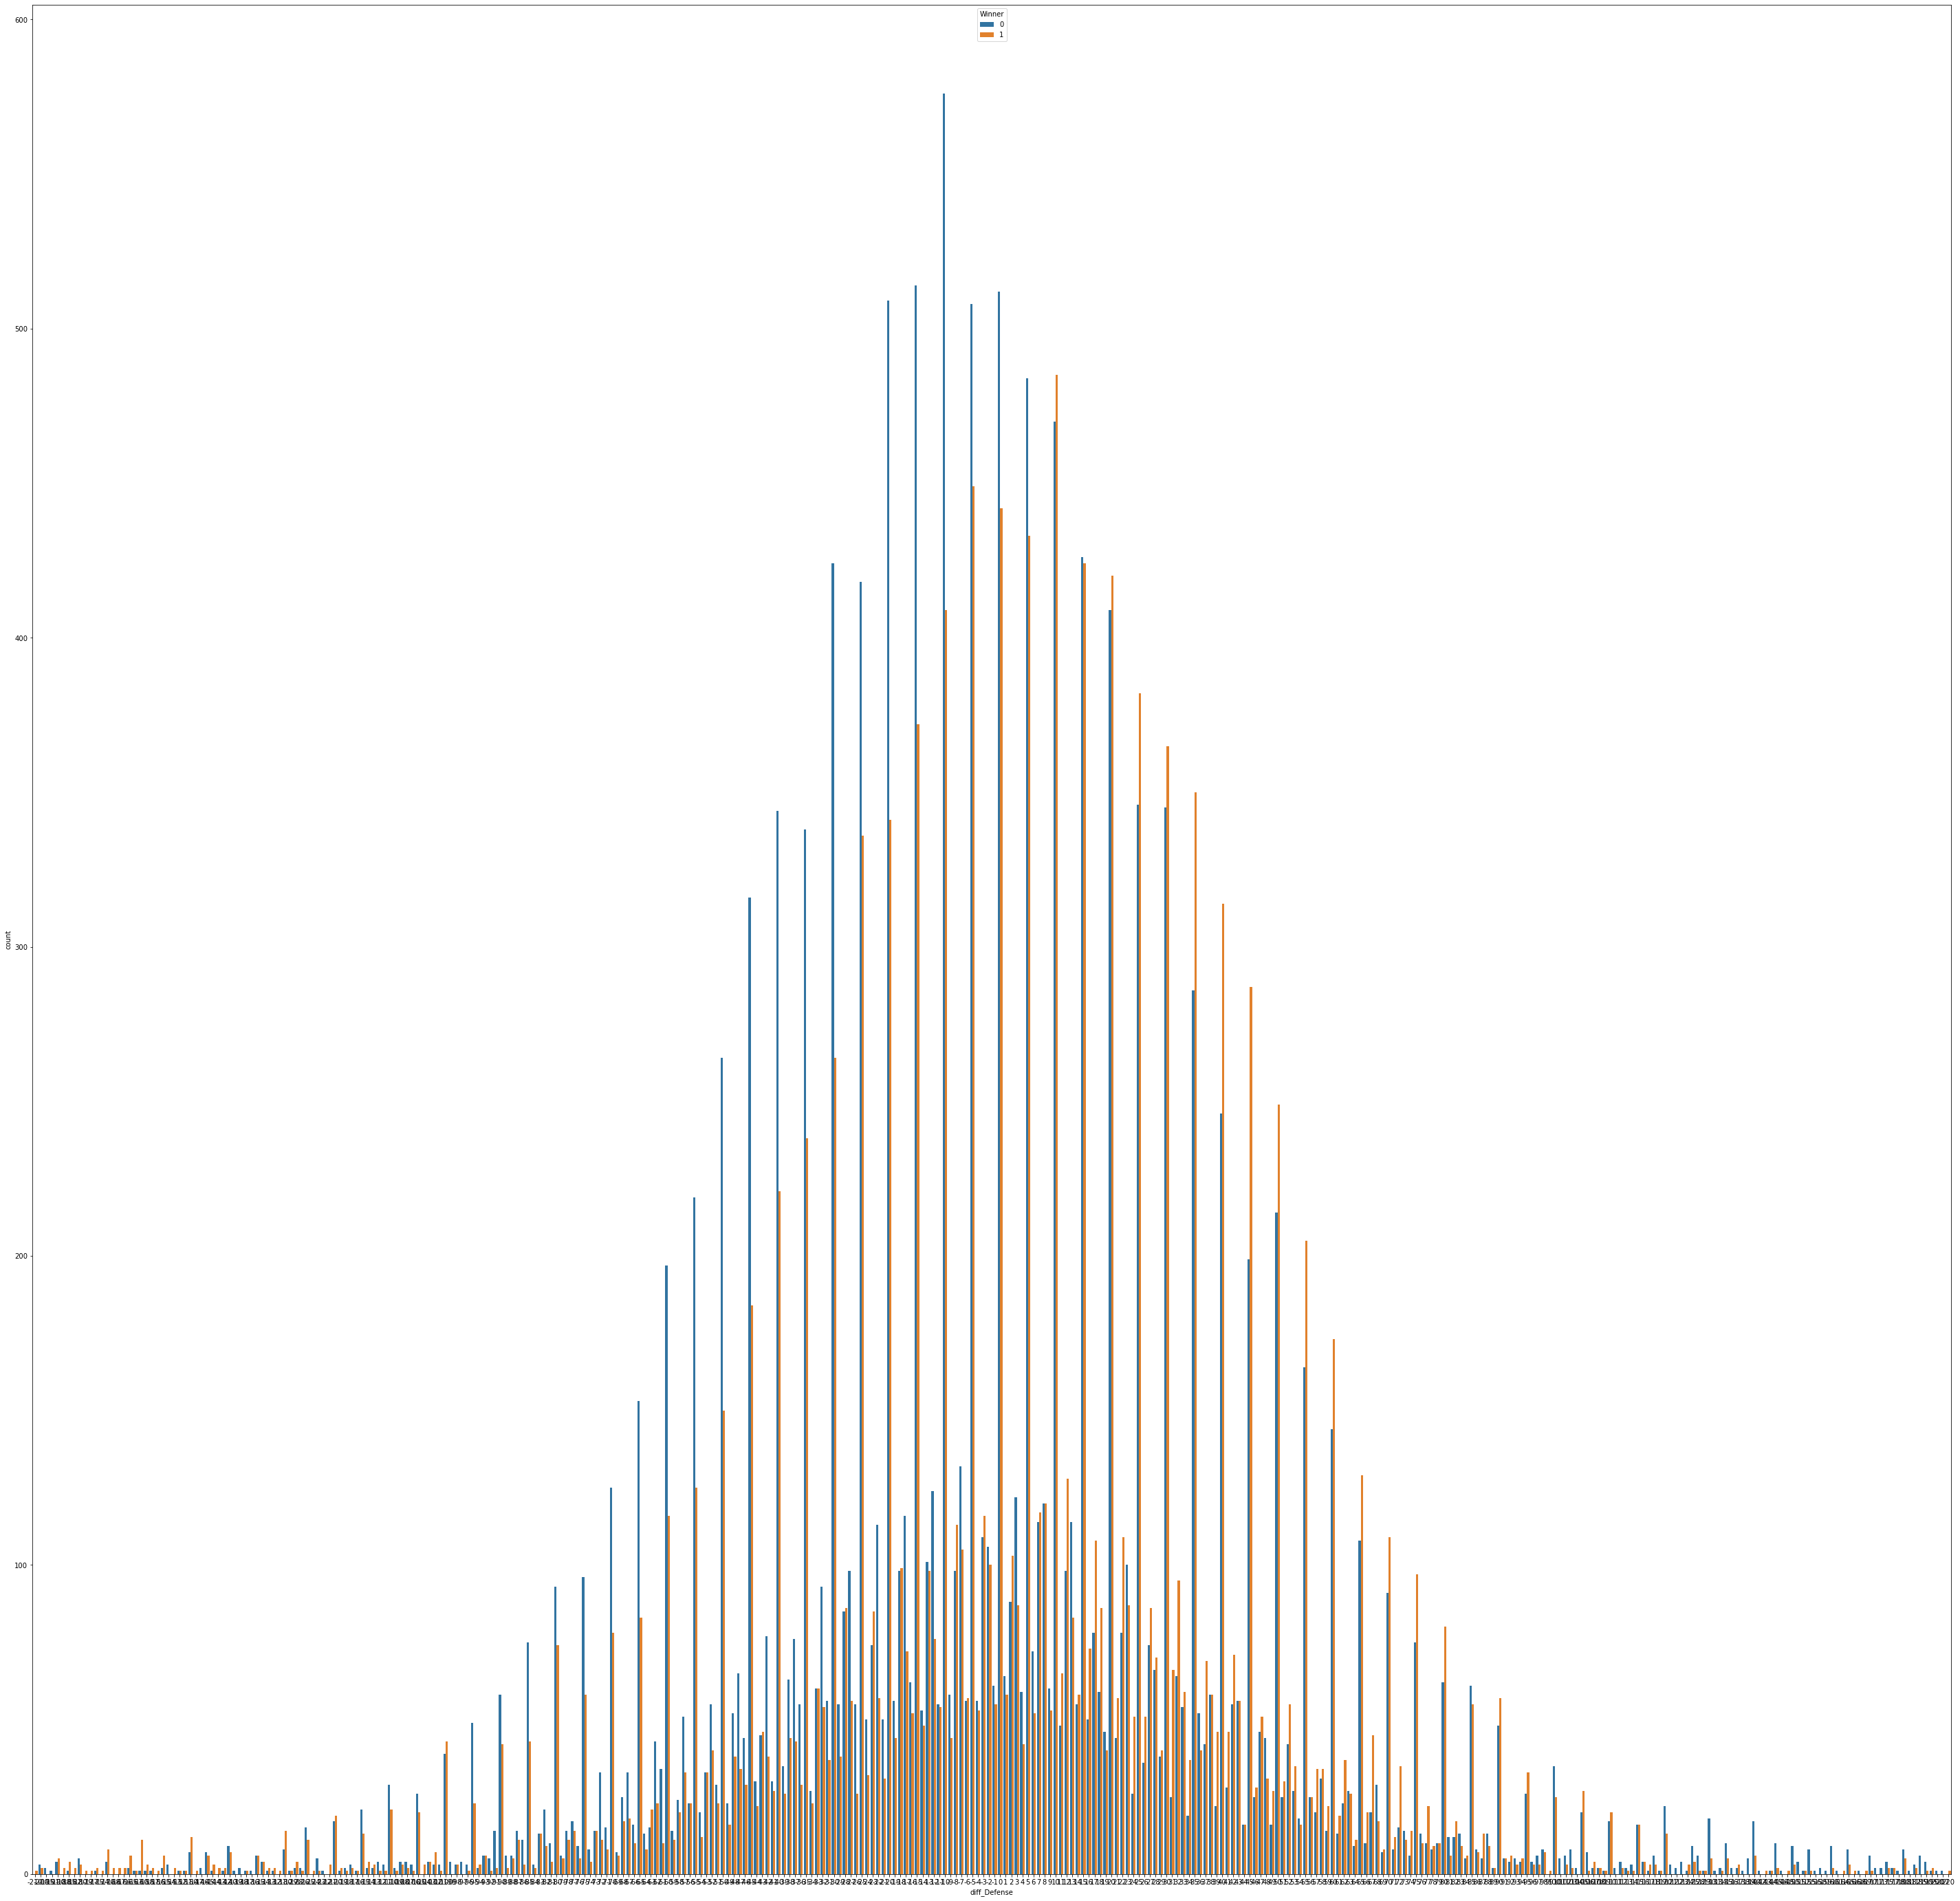

In [45]:
plt.figure(figsize=(50,50))
sns.countplot(x=train["diff_Defense"],hue=train["Winner"]);

DA QUESTO GRAFICO NON SI PUO' DIRE NULLA  I VALORI DI VINCITA DEL PRIMO E DEL SECONDO SONO STATISTICAMENTE PARAGONABILI QUINDI PROBABILMENTE QUESTA FEATURE PUO' ESSERE DROPPATA

### -SP_ATK

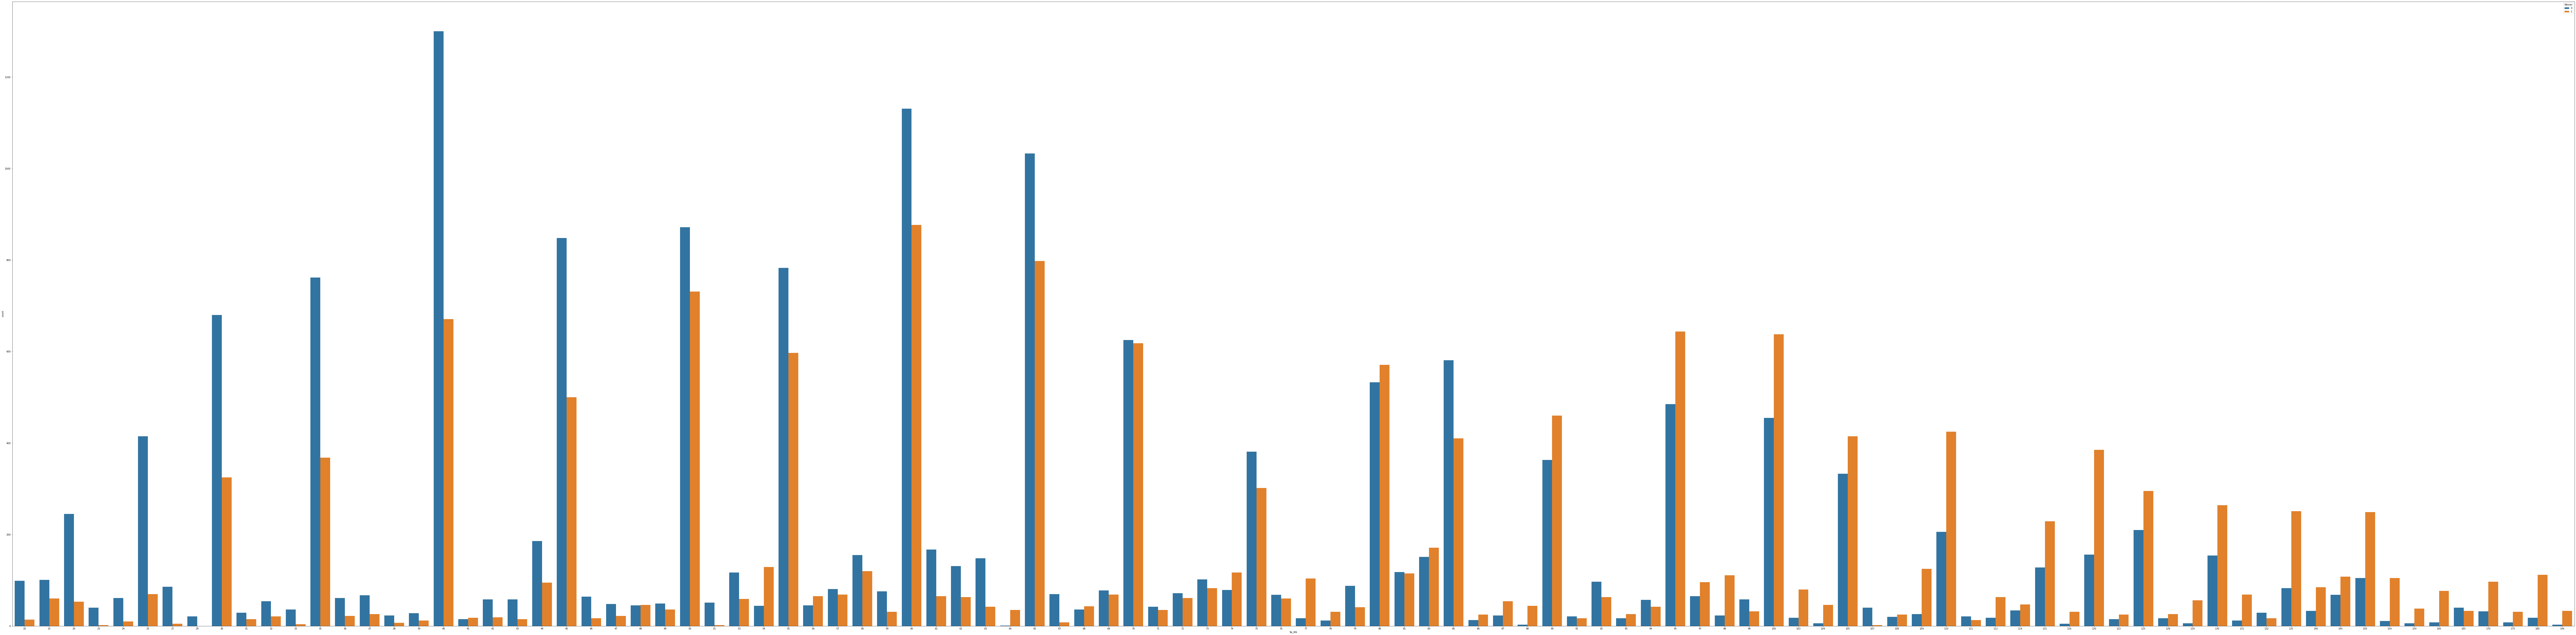

In [46]:
plt.figure(figsize=(200,50))
sns.countplot(x=train["Sp_Atk"],hue=train["Winner"]);

ANCHE IN QUESTO CASO LA DISTRIBUZIONE DI WINNER TRANNE IN ALCUNI(POCHI) PUNTI SEMBREREBBE PARAGONABILE. 
VEDO SE OTTENGO UNA CONFERMA DEFINENDO UNA NUOVA FEATURE DIFF_SP_ATK

In [47]:

train['diff_Sp_Atk']=train['Sp_Atk']-train['Sp_Atk_second']
test['diff_Sp_Atk']=test['Sp_Atk']-test['Sp_Atk_second']

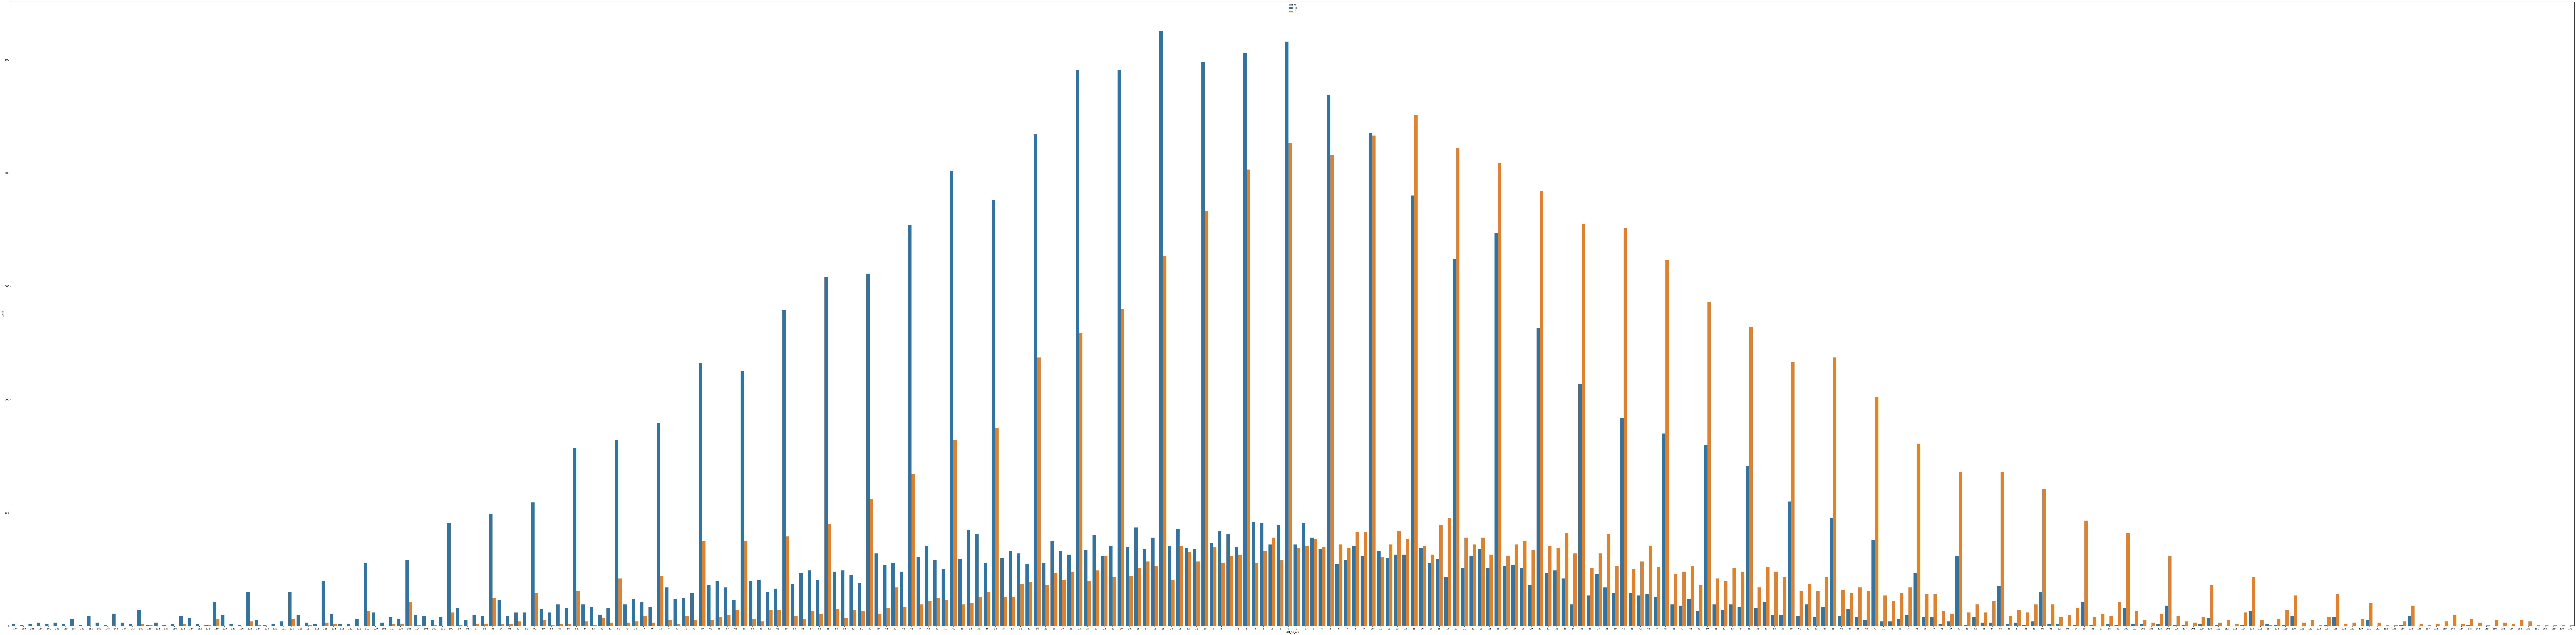

In [48]:
plt.figure(figsize=(200,50))
sns.countplot(x=train["diff_Sp_Atk"],hue=train["Winner"]);

DA QUESTO GRAFICO NOTIAMO QUALCOSA SULLE DIFFERENZE DI SPECIAL ATTACK:
- MOLTO NEGATIVE (SPECIAL ATTACK POKEMON 2 MOLTO MAGGIORE RISPETTO ALLO SPECIAL ATTACK DEL POKEMON 1) VINCE IL SECONDO
- MOLTO POSITIVE (SPECIAL ATTACK POKEMON 1 MOLTO MAGGIORE RISPETTO ALLO SPECIAL ATTACK DEL POKEMON 2) VINCE IL PRIMO

SE LO SPECIAL ATTACK 1 E' DI POCO MAGGIORE ALLO SPECIAL ATTACK 2 E VICEVERSA NON SI POSSONO FARE ASSUNZIONI



### -SP_DEF

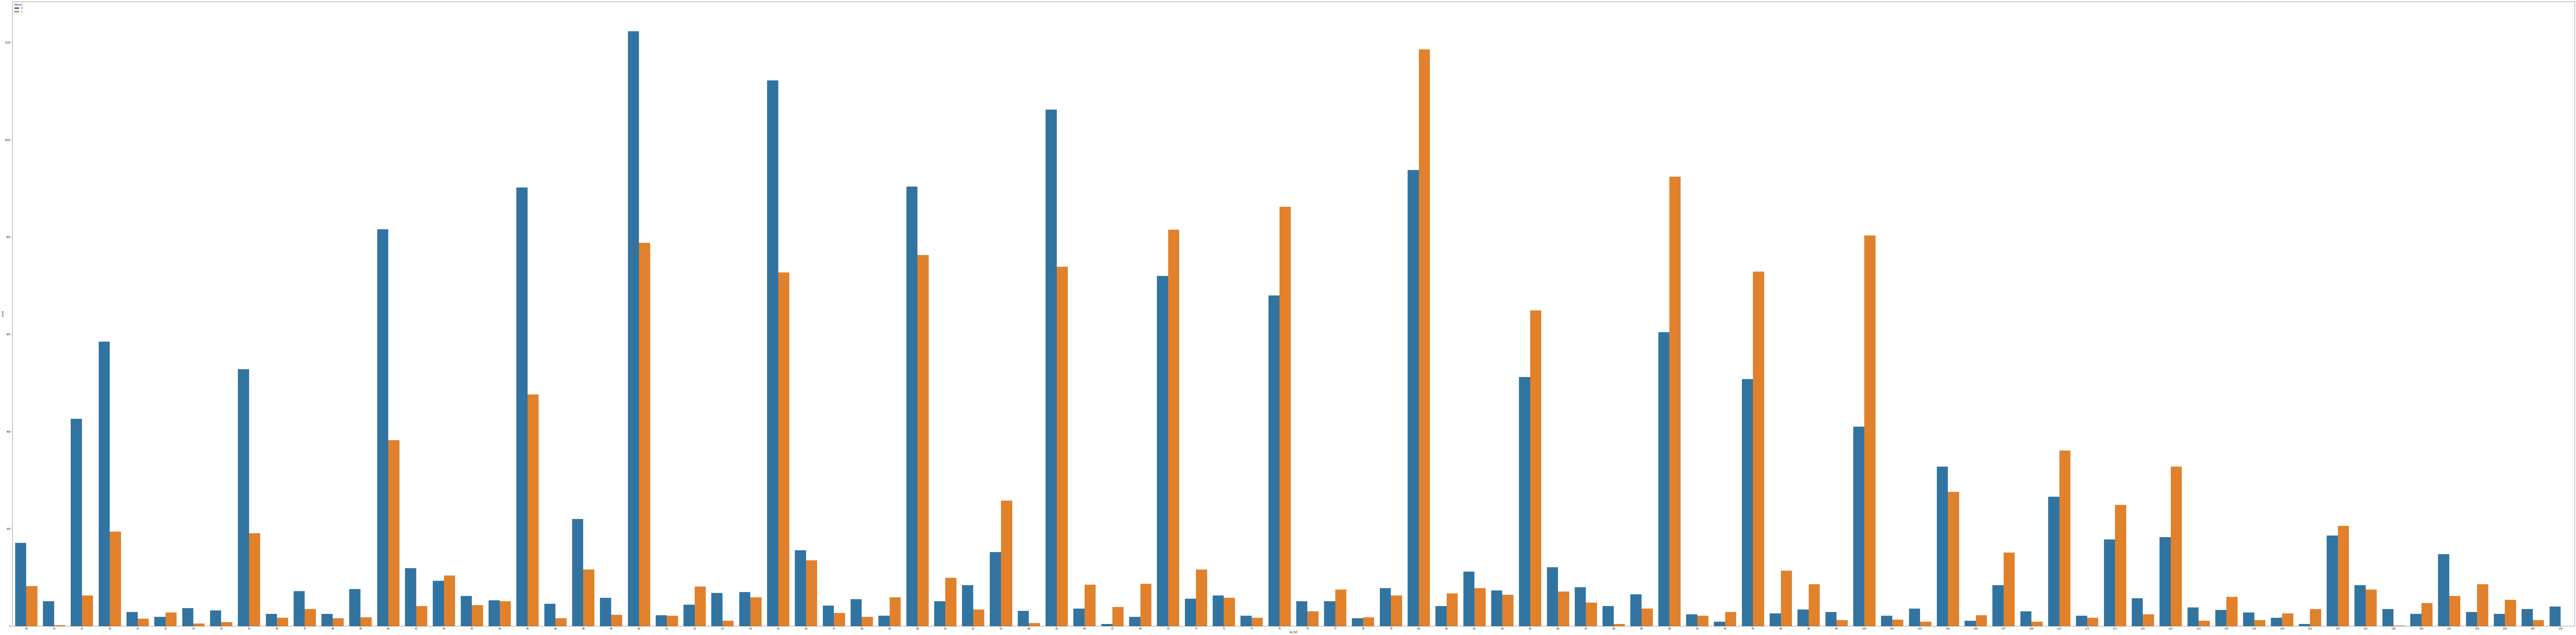

In [49]:
plt.figure(figsize=(200,50))
sns.countplot(x=train["Sp_Def"],hue=train["Winner"]);

ANCHE IN QUESTO CASO CI SONO DEI PICCHI NOTIAMO CHE MOLTI POKEMON HANNO COME VALORI DI SPECIAL DEFENSE: 
- 20;25;30;35;40;45;50;55;60;65;90;95;100;105;110;115;120
- SONO POCHI I POKEMON CHE HANNO UNA SPECIAL DEFENSE CON VALORE NON MULTIPLO DI 5
- MA SULL'ANDAMENTO DELLE VITTORE DA QUESTO GRAFICO NON SI CAPISCE MOLTO, PERCUI DEFINISCO UNA NUOVA FEATURE DIFF_SP_DEF

In [50]:
train['diff_Sp_Def']=train['Sp_Def']-train['Sp_Def_second']
test['diff_Sp_Def']=test['Sp_Def']-test['Sp_Def_second']

### -DIFF_SP_DEF

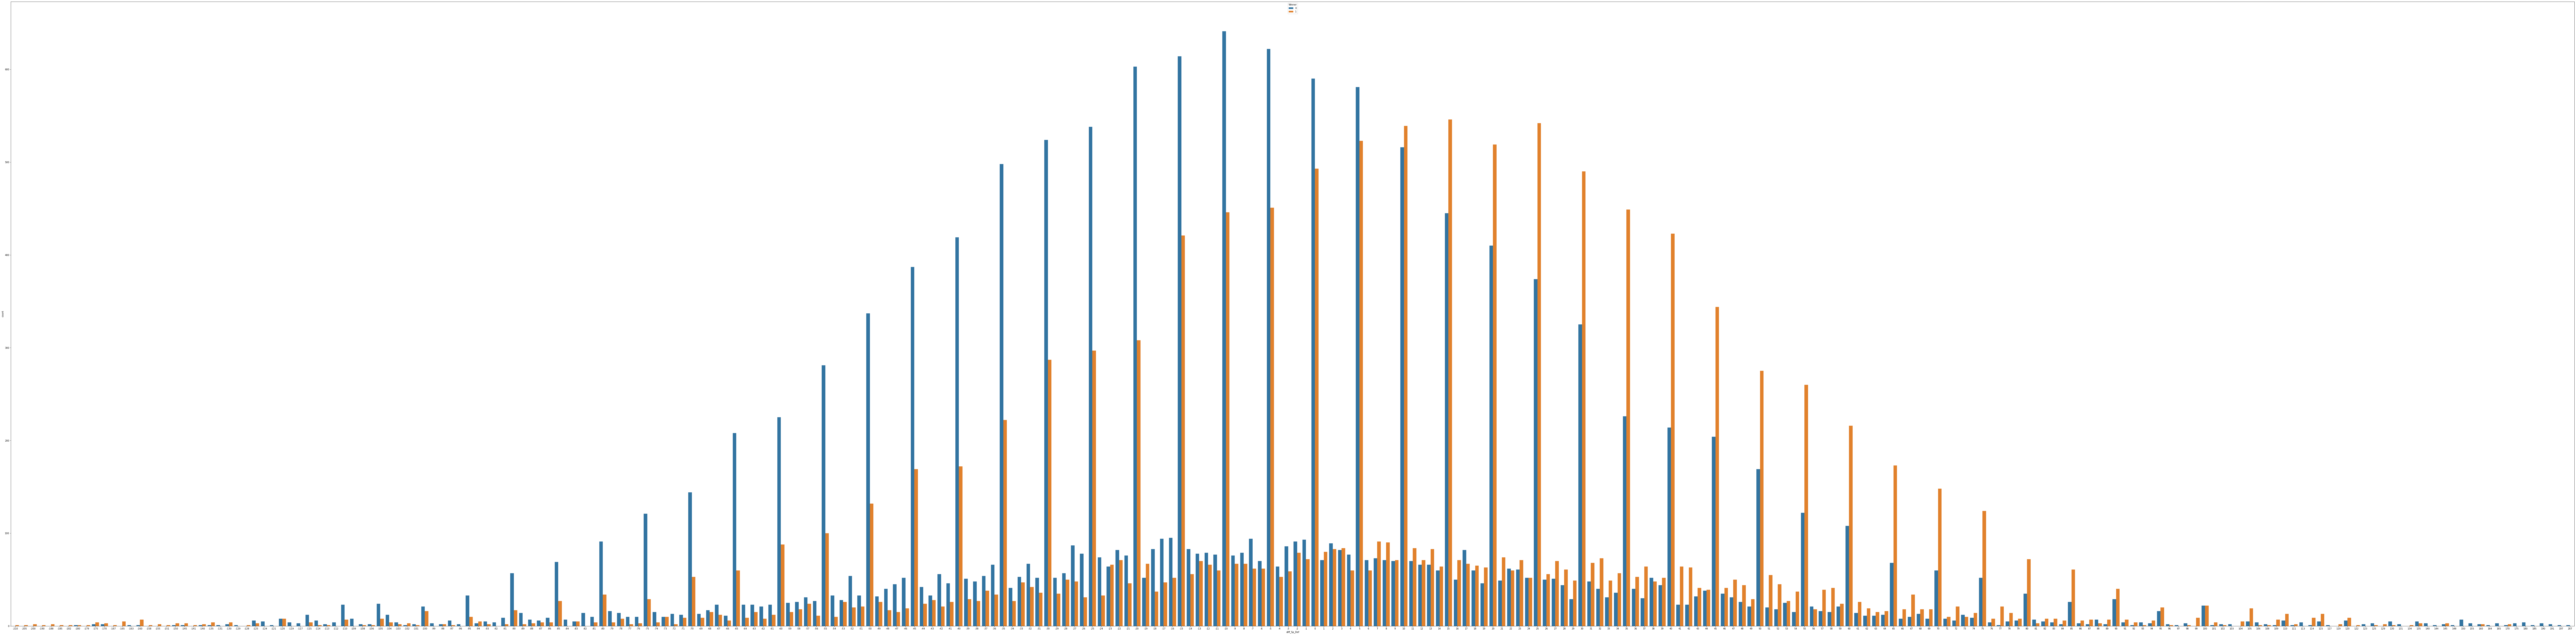

In [51]:
plt.figure(figsize=(200,50))
sns.countplot(x=train["diff_Sp_Def"],hue=train["Winner"]);

ANCHE IN QUESTO CASO PER VALORI VICINO ALLO 0 NON SI PUO' DIRE MOLTO, POSSIAMO NOTARE COME PER DIFFERENZE MOLTO GRANDI SIA CHE ESSE SIANO POSITIVE SIA CHE ESSE SIANO NEGATIVE CI SONO POCHISSIMI DATI, E PER BASSE DIFFERENZE QUINDI QUANDO SP_DEF E' PARAGONABILE FRA I DUE POKEMON NON SI PUò DIRE MOLTO 

### -LEGENDARY

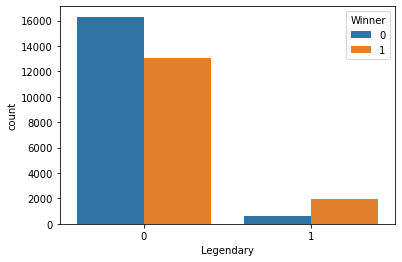

In [52]:
sns.countplot(x=train["Legendary"],hue=train["Winner"]);

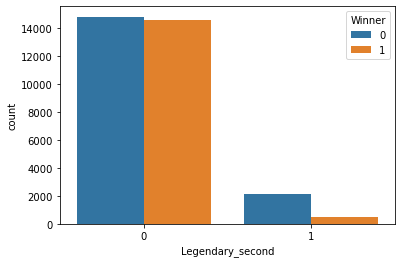

In [53]:
sns.countplot(x=train["Legendary_second"],hue=train["Winner"]);

La feature Legendary E Legendary_second invece ci mostrano che i legendari sono MOLTO pochi MA tendono a vincere, mentre per i non legendari sembrerebbe che siano molti.

# Mi stampo una heatmap che mi guarda quale sia la correlazione che ho fra le feature:
- valore negativo -> relazione di proporzionalità inversa
- valore positivo -> relazione di proporzionalità diretta
- valore pari a zero-> no correlazione (feature può essere eliminata)

<AxesSubplot:>

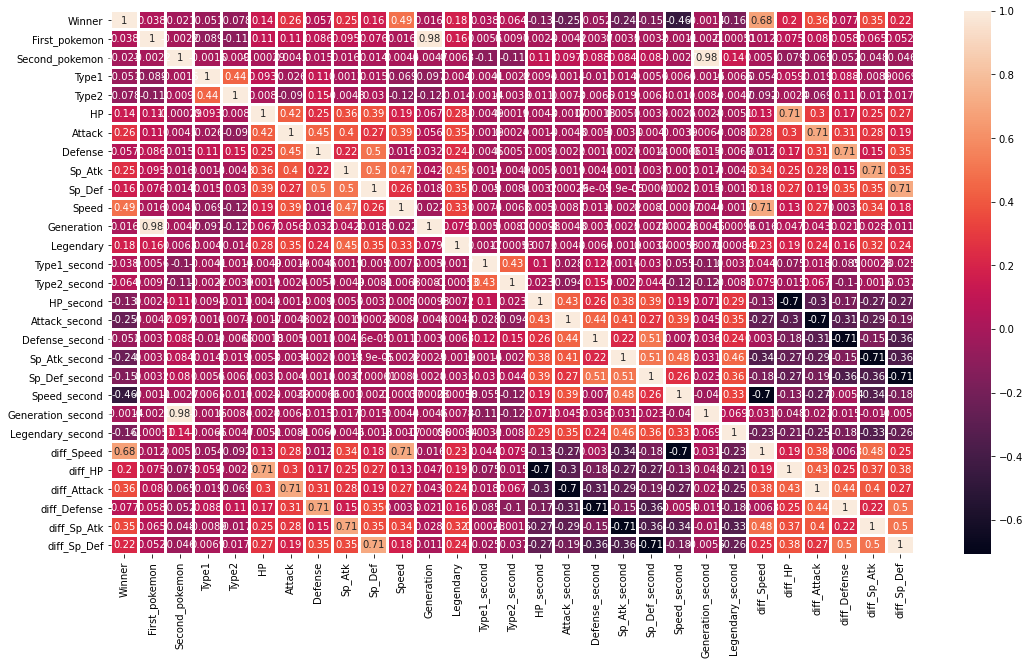

In [54]:
plt.figure(figsize=(18,10))
correlation = train.corr()
sns.heatmap(correlation, annot = True, linewidth = 2)

Dalla heatmap vediamo che le seguenti feature non sono utili per il nostro scopo:
- First_Pokemon
- Second_Pokemon
- Type1 
- Type2
- Defense 
- Generation
- Type1_second 
- Type2_second
- Defense_second
- Generation_second
- diff_Defense





Quindi si possono droppare

In [55]:
toDrop = ['First_pokemon','Second_pokemon','Type1', 'Type2','Defense','Generation','Type1_second', 'Type2_second', 'Defense_second', 'Generation_second', 'diff_Defense' ]
train = train.drop(toDrop, axis=1)

In [56]:
toDrop = ['First_pokemon','Second_pokemon','Type1', 'Type2','Defense','Generation','Type1_second', 'Type2_second', 'Defense_second', 'Generation_second', 'diff_Defense' ]
test = test.drop(toDrop, axis=1)

### SEPARO LA LABEL DALLE FEATURE 

In [57]:
y_train = train['Winner']          
X_train = train.drop(['Winner'], axis=1)      

y_test = test['Winner']           
X_test = test.drop(['Winner'], axis=1)  


### RANDOM FOREST

L’algoritmo come si può dedurre dal nome, è costituito da un insieme di alberi decisionali.
La classificazione delle istanze dei dati si ha muovendosi seguendo gli archi dalla radice (nodo iniziale dell’albero) ad una foglia dell’albero. 
Quest’ultima rappresenta il risultato predetto a partire dai valori dei vari attributi e quindi la classificazione del dato in input.
La caratteristica principale degli alberi decisionali è la loro abilità nello scegliere le features più importanti per poter dividere il set di dati in modo tale che i gruppi risultanti siano più diversi possibili fra di loro e quindi i membri del sottogruppo siano più simili possibili fra loro. 
Ciascuna regola di predizione è rappresentata dal cammino che va dal nodo radice al nodo foglia.
Per quanto riguarda la classificazione ogni singolo albero nella foresta genera una previsione di classe e la classe con maggior numero di voti diventa quindi la previsione del modello. 
Il vantaggio di avere più alberi decisionali risiede nel fatto che un gran numero di alberi non correlati protegge l’errore effettuato dai singoli alberi, in quanto mentre alcuni alberi potranno avere un output errato molti altri lo avranno corretto, quindi come gruppo gli alberi si muoveranno verso la corretta direzione.
In sostanza la maggioranza vince

In [58]:
randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)
y_pred = randomforest.predict(X_test)
acc_randomforest = round(accuracy_score(y_pred, y_test) * 100, 2)
print(acc_randomforest)
print(classification_report(y_test,y_pred))

95.35
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      4236
           1       0.94      0.96      0.95      3764

    accuracy                           0.95      8000
   macro avg       0.95      0.95      0.95      8000
weighted avg       0.95      0.95      0.95      8000



In [60]:
models = pd.DataFrame({
    'Model': [ 'Random Forest'],
    'Score': [ acc_randomforest ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Random Forest,95.35
